# **Поиск мошеннических операций в платежных транзакциях интернет-аукциона**

Платежи - это наиболее цифровая часть финансовой индустрии, что делает их особенно уязвимыми для цифрового мошенничества.
Рост мобильных платежей и конкуренция за лучшее качество обслуживания клиентов подталкивают банки к сокращению количества этапов проверки.
Это снижает эффективность подхода, основанного на правилах.
Таким образом, банки и платежные компании переходят на анализ данных, машинное обучение и методы, основанные на искусственном интеллекте.

Современные системы обнаружения мошенничества решают широкий спектр аналитических задач по выявлению всех мошеннических транзакций в платежных потоках.

**Цель состоит в том, чтобы использовать данные для разработки алгоритма машинного обучения для выявления мошенников и выполнения необходимых действий.**

LOCK_USER - Текущая транзакция заблокирована, а учетная запись пользователя ЗАБЛОКИРОВАНА. Это предотвращает выполнение пользователем каких-либо транзакций со своей учетной записью. Доступ можно восстановить только после обращения к агенту.
ALERT_AGENT - Текущая транзакция не заблокирована. Предупреждение отправляется агенту мониторинга транзакций для дальнейшего рассмотрения.

## Описание данных
## Data
1. countries.csv
	- таблица со всеми буквенно-цифровыми обозначениями стран. Возможно, вам потребуется использовать это для стандартизации кодов стран в одном формате.
2. fraudsters.csv
	- он просто содержит список идентификаторов пользователей, которые были идентифицированы как мошенники по этой проблеме
	- в таблице пользователей есть и другие мошенники, задача состоит в том, чтобы их также идентифицировать
3. users.csv
	- таблица пользовательских данных
	- **kyc** столбец указывает статус процесса проверки личности пользователя
	- **terms_version** колонок indiciates текущей версии пользователя в приложении
	- **state**
		состояние ЗАБЛОКИРОВАНО - учетная запись пользователя заблокирована, и он не может выполнять никаких транзакций. Если для этого пользователя есть транзакции, они произошли до того, как пользователь был ЗАБЛОКИРОВАН. 

4. transactions.csv
	- все транзакции, проводимые пользователями
	- **amount** и **amount_usd** выражены в целых числах в наименьшей единице. например, 5000 долларов США => 50 долларов США (поскольку самая низкая единица в долларах США - это цент, w / 100 центов = 1 доллар)
	- **entry_method**  актуален только для карточных транзакций (CARD_PAYMENT, ATM); вы можете игнорировать его для других транзакций. Значения: разное - неизвестный чип - чип на карточных журналах - магнитная полоса на карте manu - ручной ввод данных карты (продолжение) - бесконтактный / Tap mcon - особый случай магнитной полосы и бесконтактной карты
	- **source** связан с внешней стороной, которую мы используем для обработки этого типа транзакции. (например, все {CARD_PAYMENT, ATM} используют GAIA)
	- **type**
		P2P - отправка денег внутри платформы (например, отправка денег без банковского счета) BANK_TRANSFER - отправка денег извне на банкомат с банковским счетом - снятие денег в банкомате

	- **state** 
		ЗАВЕРШЕНО - транзакция была завершена, и баланс пользователя был изменен ОТКЛОНЕН / НЕУДАЧЕН - транзакция была отклонена по какой-то причине, обычно относится к недостаточному балансу ОТКРЫТО - связанная транзакция была завершена первой, но затем была отменена позже, возможно из-за клиента обратиться в банк
        
5. currency_details.csv
	- таблица с ISO-кодами и показателями валют
	- Столбец экспоненты может использоваться для преобразования целых сумм в таблице транзакций в денежные суммы. (например, для 5000 фунтов стерлингов показатель степени = 2, поэтому мы применяем: 5000 / (10 ^ 2) = 50 фунтов стерлингов)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, timedelta
import dateutil

from pprint import pprint

from scipy.stats import pearsonr
import scipy.stats as sts
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score, accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score, cross_val_predict, RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel
#from sklearn.externals import joblib
import pickle

%matplotlib inline

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [ ]:
class parameters():
    ''' Общий класс для хранения всех парамметров '''
    
    transaction_dataset = './data/transactions.csv'
    country_dataset = './data/countries.csv'
    currency_dataset = './data/currency_details.csv'
    fraudster_dataset = './data/fraudsters.csv'
    user_dataset = './data/users.csv'
    test_user_pkl = './data/test_users.pkl'

    random_state = 7

    n_folds = 3
    test_size = .3
    days_from_max_to_split = None
    
    best_pca_components_number = None
    best_pca = None

    model_pkl = './artifacts/model.pkl'
    dataset_file_name = './data/dataset.csv'
    balanced_dataset_file_name = './data/balanced_dataset.csv'
    
    cols_to_select = ['TRN_ID', 'USER_ID', 'CREATED_DATE_x', 'CURRENCY', 'AMOUNT',
                      'STATE', 'MERCHANT_CATEGORY', 'ENTRY_METHOD', 'TYPE', 'SOURCE', 'HAS_EMAIL',
                      'IS_FRAUDSTER', 'TERMS_VERSION', 'KYC', 'FAILED_SIGN_IN_ATTEMPTS', 'AGE', 'PROFILE_AGE',
                      'HOMELAND', 'HOMELAND_PHONE', 'DAY_OF_TRANSACTION', 'HOUR_OF_TRANSACTION', 'IS_CRYPTO']
    cat_features = ['ENTRY_METHOD', 'TYPE', 'SOURCE', 'STATE', 'MERCHANT_CATEGORY',
                    'TERMS_VERSION', 'KYC', 'CURRENCY']
    id_features = ['USER_ID','TRN_ID']
    target_feature = 'IS_FRAUDSTER'

### Проверить все данные

In [ ]:
def load_file(filename, encoding='windows-1251'):
    ''' Функция загрузки csv-файла и возврат фрейма данных и некоторой статистики'''

    print(f'Loading file: {filename}')
    df = pd.read_csv(filename, encoding='windows-1251')
    print(f'Shape of the dataset: {df.shape}')
    pprint(df.describe())
    pprint(df.head())

    return df

In [ ]:
trn_df = load_file(parameters.transaction_dataset)

Loading file: ./data/transactions.csv
Shape of the dataset: (688651, 11)
             AMOUNT
count  6.886510e+05
mean   3.172575e+04
std    2.304381e+06
min    0.000000e+00
25%    4.800000e+02
50%    1.420000e+03
75%    5.000000e+03
max    9.000000e+08
  CURRENCY  AMOUNT      STATE             CREATED_DATE MERCHANT_CATEGORY  \
0      GBP     175  COMPLETED  2017-12-20 12:46:20.294              cafe   
1      EUR    2593  COMPLETED  2017-12-20 12:38:47.232               bar   
2      EUR    1077  COMPLETED  2017-12-20 12:34:39.668               NaN   
3      GBP     198  COMPLETED  2017-12-20 12:45:50.555       supermarket   
4      EUR     990  COMPLETED  2017-12-20 12:45:32.722               NaN   

  MERCHANT_COUNTRY ENTRY_METHOD                               USER_ID  \
0              GBR         cont  8f99c254-7cf2-4e35-b7e4-53804d42445d   
1              AUS         cont  ed773c34-2b83-4f70-a691-6a7aa1cb9f11   
2              CZE         cont  eb349cc1-e986-4bf4-bb75-72280a7b8680  

In [ ]:
cntr_df = load_file(parameters.country_dataset)

Loading file: ./data/countries.csv
Shape of the dataset: (226, 5)
          NUMCODE    PHONECODE
count  226.000000   226.000000
mean   433.628319   531.371681
std    251.971451   648.237826
min      4.000000     0.000000
25%    219.000000   220.250000
50%    432.000000   354.500000
75%    645.250000   686.750000
max    894.000000  7370.000000
  CODE            NAME CODE3  NUMCODE  PHONECODE
0   AF     Afghanistan   AFG        4         93
1   AL         Albania   ALB        8        355
2   DZ         Algeria   DZA       12        213
3   AS  American Samoa   ASM       16       1684
4   AO          Angola   AGO       24        244


In [ ]:
cur_df = load_file(parameters.currency_dataset)

Loading file: ./data/currency_details.csv
Shape of the dataset: (184, 3)
         EXPONENT
count  184.000000
mean     1.961957
std      1.189052
min      0.000000
25%      2.000000
50%      2.000000
75%      2.000000
max      8.000000
   CCY  EXPONENT  IS_CRYPTO
0  AED         2      False
1  AFN         2      False
2  ALL         2      False
3  AMD         2      False
4  ANG         2      False


In [ ]:
fraud_df = load_file(parameters.fraudster_dataset)

Loading file: ./data/fraudsters.csv
Shape of the dataset: (298, 1)
                                     USER_ID
count                                    298
unique                                   298
top     840a2f6a-b344-4e6b-84fe-ff27531f3125
freq                                       1
                                USER_ID
0  5270b0f4-2e4a-4ec9-8648-2135312ac1c4
1  848fc1b1-096c-40f7-b04a-1399c469e421
2  27c76eda-e159-4df3-845a-e13f4e28a8b5
3  a27088ef-9452-403d-9bbb-f7b10180cdda
4  fb23710b-609a-49bf-8a9a-be49c59ce6de


In [ ]:
user_df = load_file(parameters.user_dataset)

Loading file: ./data/users.csv
Shape of the dataset: (9944, 11)
         HAS_EMAIL   BIRTH_YEAR  FAILED_SIGN_IN_ATTEMPTS
count  9944.000000  9944.000000              9944.000000
mean      0.946702  1983.553298                 0.008045
std       0.224639    11.350379                 0.129737
min       0.000000  1927.000000                 0.000000
25%       1.000000  1978.000000                 0.000000
50%       1.000000  1986.000000                 0.000000
75%       1.000000  1992.000000                 0.000000
max       1.000000  2000.000000                 6.000000
                                     ID  HAS_EMAIL   PHONE_COUNTRY  \
0  1872820f-e3ac-4c02-bdc7-727897b60043          1  GB||JE||IM||GG   
1  545ff94d-66f8-4bea-b398-84425fb2301e          1  GB||JE||IM||GG   
2  10376f1a-a28a-4885-8daa-c8ca496026bb          1              ES   
3  fd308db7-0753-4377-879f-6ecf2af14e4f          1              FR   
4  755fe256-a34d-4853-b7ca-d9bb991a86d3          1  GB||JE||IM||GG   

  

Users for final test

In [ ]:
#test_users = joblib.load(parameters.test_user_pkl)
test_users = pickle.load(open(parameters.test_user_pkl,'rb'))
print(f'Length of the list of test users: {len(test_users)}')
test_users[:5]

Length of the list of test users: 84


['0c6ec0f3-d062-4998-9ddd-5f7995164126',
 'b77d5b47-244a-41b8-8abd-62019463bd32',
 'b761cde7-d548-474f-a909-97702cdf02d9',
 'c63d1b5b-62ce-4f01-8192-9852106f663c',
 'ef4a0a80-2825-4013-98fb-09ff212912b0']

### Начнем с ПОЛЬЗОВАТЕЛЕЙ

In [ ]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9944 entries, 0 to 9943
Data columns (total 11 columns):
ID                         9944 non-null object
HAS_EMAIL                  9944 non-null int64
PHONE_COUNTRY              9944 non-null object
IS_FRAUDSTER               9944 non-null bool
TERMS_VERSION              8417 non-null object
CREATED_DATE               9944 non-null object
STATE                      9944 non-null object
COUNTRY                    9944 non-null object
BIRTH_YEAR                 9944 non-null int64
KYC                        9944 non-null object
FAILED_SIGN_IN_ATTEMPTS    9944 non-null int64
dtypes: bool(1), int64(3), object(7)
memory usage: 786.7+ KB


In [ ]:
# В TERMS_VERSION есть NaN - заполним его версией "Undefined"
user_df['TERMS_VERSION'] = user_df['TERMS_VERSION'].fillna("Undefined")

In [ ]:
user_df['IS_FRAUDSTER'].value_counts()

False    9646
True      298
Name: IS_FRAUDSTER, dtype: int64

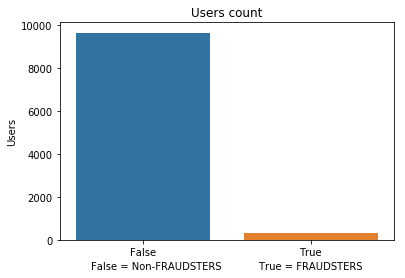

In [ ]:
sns.barplot(x=user_df['IS_FRAUDSTER'].value_counts().index, y=user_df['IS_FRAUDSTER'].value_counts())
plt.title('Users count')
plt.ylabel('Users')
plt.xlabel('False = Non-FRAUDSTERS            True = FRAUDSTERS');

In [ ]:
# Проверяем, что у нас одни и те же пользователи как мошенники в двух наборах данных
set(user_df[user_df['IS_FRAUDSTER']==True]['ID'].values).issubset(set(fraud_df['USER_ID'].values)) and set(fraud_df['USER_ID'].values).issubset(set(user_df[user_df['IS_FRAUDSTER']==True]['ID'].values))

True

In [ ]:
user_df[user_df['IS_FRAUDSTER']==True].head()

ID  HAS_EMAIL   PHONE_COUNTRY  \
8166  5270b0f4-2e4a-4ec9-8648-2135312ac1c4          1  GB||JE||IM||GG   
8167  848fc1b1-096c-40f7-b04a-1399c469e421          1              PL   
8168  27c76eda-e159-4df3-845a-e13f4e28a8b5          1  GB||JE||IM||GG   
8169  a27088ef-9452-403d-9bbb-f7b10180cdda          1              IN   
8170  fb23710b-609a-49bf-8a9a-be49c59ce6de          1              LT   

      IS_FRAUDSTER TERMS_VERSION                CREATED_DATE   STATE COUNTRY  \
8166          True     Undefined  2017-09-19 01:55:22.376000  LOCKED      GB   
8167          True    2018-05-25  2018-06-16 15:55:43.800000  LOCKED      GB   
8168          True    2018-05-25  2018-05-11 18:20:45.608000  LOCKED      GB   
8169          True    2018-05-25  2018-05-18 16:41:12.267000  LOCKED      BE   
8170          True    2018-03-20  2018-03-29 13:37:29.736000  LOCKED      LT   

      BIRTH_YEAR     KYC  FAILED_SIGN_IN_ATTEMPTS  
8166        1988    NONE                        0  
8167        1994  PASSED                        0  
8168        1997  PASSED                        0  
8169        1989  PASSED                        0  
8170        1992  PASSED                        0

In [ ]:
# Убедимся, что заблокированы только мошенники, поэтому нам больше не нужно иметь STATE пользователя
user_df[user_df['IS_FRAUDSTER']==True]['STATE'].value_counts()

LOCKED    298
Name: STATE, dtype: int64

In [ ]:
user_df.drop('STATE', axis=1, inplace=True)

In [ ]:
# Создаем переменную AGE как возраст на дату CREATED_DATE профиля в системе
user_df['AGE'] = user_df.apply(lambda x: datetime.strptime(x['CREATED_DATE'], '%Y-%m-%d %H:%M:%S.%f').year-x['BIRTH_YEAR'], axis=1)
# Нам больше не нужен BIRTH_YEAR  - drop
user_df.drop('BIRTH_YEAR', axis=1, inplace=True)

In [ ]:
# Создадим двоичную функцию, которая находится в стране в Phone_country
user_df['HOMELAND_PHONE'] = user_df.apply(lambda x: 1 if x['COUNTRY'].upper() in x['PHONE_COUNTRY'].upper().split('||') else 0, axis=1)

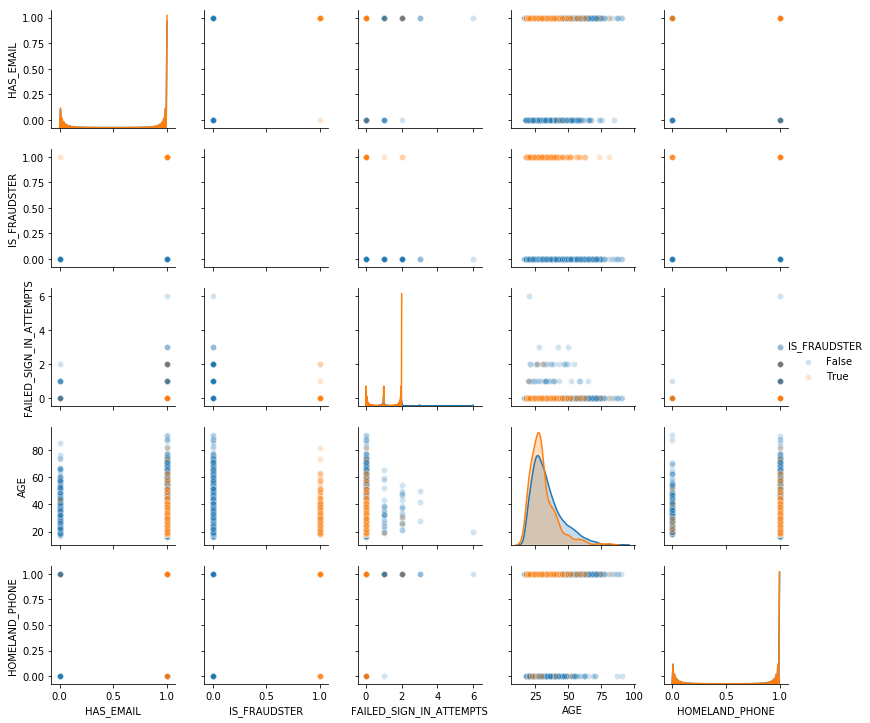

In [ ]:
g=sns.pairplot(data=user_df,plot_kws={'alpha':0.2},hue='IS_FRAUDSTER');
g.fig.set_size_inches(12,10)

В пользовательском наборе данных есть один признак мошенничества: у мошенников есть максимум две попытки входа в систему. Вероятно, они боялись, что их поймают.

In [ ]:
user_df[user_df['IS_FRAUDSTER']==True]['FAILED_SIGN_IN_ATTEMPTS'].value_counts()

0    295
2      2
1      1
Name: FAILED_SIGN_IN_ATTEMPTS, dtype: int64

In [ ]:
user_df[user_df['IS_FRAUDSTER']==False]['FAILED_SIGN_IN_ATTEMPTS'].value_counts()

0    9600
1      24
2      18
3       3
6       1
Name: FAILED_SIGN_IN_ATTEMPTS, dtype: int64

Итак, мои предварительные наблюдения для мошенников:

* если страна продавца отличается от страны / phone_country пользователя

* если валюта транзакции отличается от страны пользователя

* если период на платформе очень маленький

* если период между транзакциями слишком мал

* если количество транзакций не является обычным для этого пользователя

* или MERCHANT_CATEGORY не является общим для этого пользователя

* или TYPE не является общим для этого пользователя

Новые идеи:
* несколько банковских переводов или одна операция через банкомат приводят к БЛОКИРОВКЕ

* Страна торговца NAN приводит к ALERT и LOCK

* entry-method == man привести к ALERT

### **Разработка функций**

#### Теперь посмотрим на транзакции

In [ ]:
trn_df.head()

CURRENCY  AMOUNT      STATE             CREATED_DATE MERCHANT_CATEGORY  \
0      GBP     175  COMPLETED  2017-12-20 12:46:20.294              cafe   
1      EUR    2593  COMPLETED  2017-12-20 12:38:47.232               bar   
2      EUR    1077  COMPLETED  2017-12-20 12:34:39.668               NaN   
3      GBP     198  COMPLETED  2017-12-20 12:45:50.555       supermarket   
4      EUR     990  COMPLETED  2017-12-20 12:45:32.722               NaN   

  MERCHANT_COUNTRY ENTRY_METHOD                               USER_ID  \
0              GBR         cont  8f99c254-7cf2-4e35-b7e4-53804d42445d   
1              AUS         cont  ed773c34-2b83-4f70-a691-6a7aa1cb9f11   
2              CZE         cont  eb349cc1-e986-4bf4-bb75-72280a7b8680   
3              GBR         cont  dc78fbc4-c936-45d3-a813-e2477ac6d74b   
4              FRA         cont  32958a5c-2532-42f7-94f9-127f2a812a55   

           TYPE SOURCE                                    ID  
0  CARD_PAYMENT   GAIA  b3332e6f-7865-4d6e-b6a5-370bc75568d8  
1  CARD_PAYMENT   GAIA  853d9ff8-a007-40ef-91a2-7d81e29a309a  
2  CARD_PAYMENT   GAIA  04de8238-7828-4e46-91f1-050a9aa7a9df  
3  CARD_PAYMENT   GAIA  2b790b9b-c312-4098-a4b3-4830fc8cda53  
4  CARD_PAYMENT   GAIA  6469fc3a-e535-41e9-91b9-acb46d1cc65d

In [ ]:
# посмотрим на мошенника
trn_df[trn_df['USER_ID']=='fb23710b-609a-49bf-8a9a-be49c59ce6de'].sort_values('CREATED_DATE', ascending=True)

CURRENCY  AMOUNT      STATE             CREATED_DATE  \
132324      GBP    5000  COMPLETED  2018-04-06 18:43:33.955   
132344      GBP    4709  COMPLETED  2018-04-06 18:53:35.634   
142701      GBP    6500  COMPLETED  2018-04-09 14:53:30.372   
142924      GBP    6000  COMPLETED  2018-04-09 17:23:08.928   

        MERCHANT_CATEGORY MERCHANT_COUNTRY ENTRY_METHOD  \
132324                NaN              NaN         misc   
132344  point_of_interest              LTU         manu   
142701                NaN              NaN         misc   
142924                NaN              NaN         misc   

                                     USER_ID          TYPE    SOURCE  \
132324  fb23710b-609a-49bf-8a9a-be49c59ce6de         TOPUP     MINOS   
132344  fb23710b-609a-49bf-8a9a-be49c59ce6de  CARD_PAYMENT      GAIA   
142701  fb23710b-609a-49bf-8a9a-be49c59ce6de         TOPUP     MINOS   
142924  fb23710b-609a-49bf-8a9a-be49c59ce6de           P2P  INTERNAL   

                                          ID  
132324  961f9451-2d7d-4c62-8593-bf44d15d38b0  
132344  953623dd-4d61-4f1a-b760-13fda4217b3b  
142701  eb2c9e9d-bffc-4347-9d86-28b6f0dea32d  
142924  823e2403-eee1-4c74-beae-c53fdffdaae0

Обучим модель только на пользователях с транзакциями:

In [ ]:
trn_df = trn_df.rename({'ID': 'TRN_ID'}, axis=1)

In [ ]:
df = trn_df.merge(user_df, left_on="USER_ID", right_on="ID").drop(['ID'],axis=1)
print(df.shape)
df.head()

(638742, 21)


CURRENCY  AMOUNT      STATE           CREATED_DATE_x MERCHANT_CATEGORY  \
0      GBP     175  COMPLETED  2017-12-20 12:46:20.294              cafe   
1      GBP     175  COMPLETED  2017-12-19 12:40:55.325              cafe   
2      GBP     220  COMPLETED  2017-12-19 12:45:05.706  department_store   
3      GBP     210  COMPLETED  2017-12-21 07:42:25.629               NaN   
4      GBP     485  COMPLETED  2017-12-21 08:36:56.132              cafe   

  MERCHANT_COUNTRY ENTRY_METHOD                               USER_ID  \
0              GBR         cont  8f99c254-7cf2-4e35-b7e4-53804d42445d   
1              GBR         cont  8f99c254-7cf2-4e35-b7e4-53804d42445d   
2              GBR         cont  8f99c254-7cf2-4e35-b7e4-53804d42445d   
3              GBR         cont  8f99c254-7cf2-4e35-b7e4-53804d42445d   
4              GBR         cont  8f99c254-7cf2-4e35-b7e4-53804d42445d   

           TYPE SOURCE  ... HAS_EMAIL   PHONE_COUNTRY IS_FRAUDSTER  \
0  CARD_PAYMENT   GAIA  ...         1  GB||JE||IM||GG        False   
1  CARD_PAYMENT   GAIA  ...         1  GB||JE||IM||GG        False   
2  CARD_PAYMENT   GAIA  ...         1  GB||JE||IM||GG        False   
3  CARD_PAYMENT   GAIA  ...         1  GB||JE||IM||GG        False   
4  CARD_PAYMENT   GAIA  ...         1  GB||JE||IM||GG        False   

   TERMS_VERSION              CREATED_DATE_y COUNTRY     KYC  \
0     2018-05-25  2017-09-28 11:53:55.810000      GB  PASSED   
1     2018-05-25  2017-09-28 11:53:55.810000      GB  PASSED   
2     2018-05-25  2017-09-28 11:53:55.810000      GB  PASSED   
3     2018-05-25  2017-09-28 11:53:55.810000      GB  PASSED   
4     2018-05-25  2017-09-28 11:53:55.810000      GB  PASSED   

  FAILED_SIGN_IN_ATTEMPTS  AGE  HOMELAND_PHONE  
0                       0   55               1  
1                       0   55               1  
2                       0   55               1  
3                       0   55               1  
4                       0   55               1  

[5 rows x 21 columns]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 638742 entries, 0 to 638741
Data columns (total 21 columns):
CURRENCY                   638742 non-null object
AMOUNT                     638742 non-null int64
STATE                      638742 non-null object
CREATED_DATE_x             638742 non-null object
MERCHANT_CATEGORY          208677 non-null object
MERCHANT_COUNTRY           447017 non-null object
ENTRY_METHOD               638742 non-null object
USER_ID                    638742 non-null object
TYPE                       638742 non-null object
SOURCE                     638742 non-null object
TRN_ID                     638742 non-null object
HAS_EMAIL                  638742 non-null int64
PHONE_COUNTRY              638742 non-null object
IS_FRAUDSTER               638742 non-null bool
TERMS_VERSION              638742 non-null object
CREATED_DATE_y             638742 non-null object
COUNTRY                    638742 non-null object
KYC                        638742 non-null 

In [ ]:
# Заменим NaN на 'Undefined' в MERCHANT_CATEGORY и MERCHANT_COUNTRY
df = df.fillna('Undefined')

In [ ]:
df['CREATED_DATE_x'] = df['CREATED_DATE_x'].apply(lambda x: datetime.strptime(x+('000' if '.' in x else '.000000'), '%Y-%m-%d %H:%M:%S.%f'))
df['CREATED_DATE_y'] = df['CREATED_DATE_y'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f'))

In [ ]:
df['DAY_OF_TRANSACTION'] = df['CREATED_DATE_x'].apply(lambda x: int(x.strftime('%w')))
df['HOUR_OF_TRANSACTION'] = df['CREATED_DATE_x'].apply(lambda x: int(x.strftime('%H')))

In [ ]:
# Создадим переменную AGE как возраст на дату CREATED_DATE профиля в системе
df['PROFILE_AGE'] = df.apply(lambda x: (x['CREATED_DATE_x'] - x['CREATED_DATE_y']).days, axis=1)

In [ ]:
# calc период набора данных для раделения при train/test
period = (df['CREATED_DATE_x'].max() - df['CREATED_DATE_x'].min()).days
print(f'Period of data is {period} days.')
#df['CREATED_DATE_x'] = df['CREATED_DATE_x'].apply(lambda x: x.strftime("%Y-%m-%d %H:%M:%S"))

Period of data is 940 days.


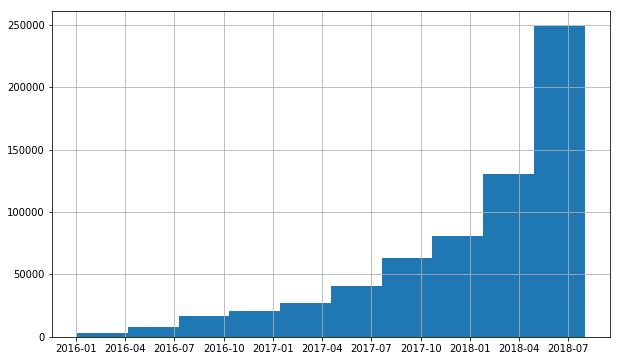

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
df['CREATED_DATE_x'].hist();

In [ ]:
df['CREATED_DATE_x_date'] = df['CREATED_DATE_x'].apply(lambda x: x.date())

In [ ]:
period_df = df.groupby(['CREATED_DATE_x_date']).agg('count')[['AMOUNT']].reset_index()
period_df.head()

CREATED_DATE_x_date  AMOUNT
0          2016-01-03       1
1          2016-01-04       6
2          2016-01-05       2
3          2016-01-06       1
4          2016-01-07       3

In [ ]:
period_df['cumsum'] = period_df['AMOUNT'].cumsum()/period_df['AMOUNT'].sum()
print(period_df[period_df['cumsum']>=(1-parameters.test_size)].head(1)['CREATED_DATE_x_date'].values[0])
period_df[period_df['cumsum']>=(1-parameters.test_size)].head()

2018-05-24


CREATED_DATE_x_date  AMOUNT    cumsum
869          2018-05-24    2382  0.702650
870          2018-05-25    2818  0.707062
871          2018-05-26    2650  0.711210
872          2018-05-27    2288  0.714793
873          2018-05-28    2502  0.718710

In [ ]:
delta_from_max_date = (df['CREATED_DATE_x_date'].max() - period_df[period_df['cumsum']>=(1-parameters.test_size)].head(1)['CREATED_DATE_x_date'].values[0]).days

In [ ]:
print(f'We need to get only {delta_from_max_date} days from max_date back to history to get test_size = {parameters.test_size}')

We need to get only 68 days from max_date back to history to get test_size = 0.3


In [ ]:
print(f"Date to split TRAIN and TEST is {df['CREATED_DATE_x_date'].max() - timedelta(days = delta_from_max_date)}")

Date to split TRAIN and TEST is 2018-05-24


In [ ]:
parameters.days_from_max_to_split = delta_from_max_date

### **Распределение транзакций по дате (created_date_x) смещено влево**

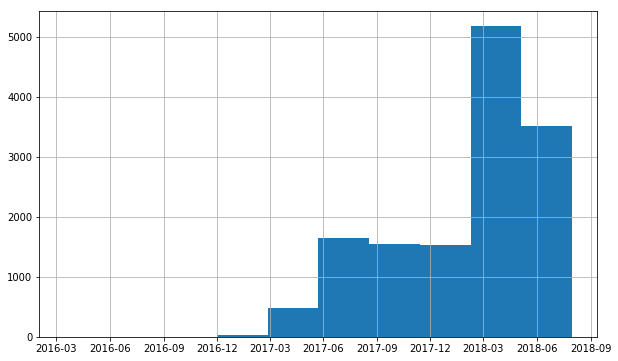

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
df[df['IS_FRAUDSTER']==1]['CREATED_DATE_x'].hist();

### **Распределение транзакций мошенника по дате (created_date_x) смещено влево**

In [ ]:
# CREATED_DATE_y больше не нужен, drop их
df.drop(['CREATED_DATE_y'], axis=1, inplace=True)

In [ ]:
# Преобразуем логическую переменную IS_FRAUDSTER в двоичную
df['IS_FRAUDSTER'] = df['IS_FRAUDSTER'].astype(int)

In [ ]:
print(df.info())
print(df.describe().T)
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 638742 entries, 0 to 638741
Data columns (total 24 columns):
CURRENCY                   638742 non-null object
AMOUNT                     638742 non-null int64
STATE                      638742 non-null object
CREATED_DATE_x             638742 non-null datetime64[ns]
MERCHANT_CATEGORY          638742 non-null object
MERCHANT_COUNTRY           638742 non-null object
ENTRY_METHOD               638742 non-null object
USER_ID                    638742 non-null object
TYPE                       638742 non-null object
SOURCE                     638742 non-null object
TRN_ID                     638742 non-null object
HAS_EMAIL                  638742 non-null int64
PHONE_COUNTRY              638742 non-null object
IS_FRAUDSTER               638742 non-null int64
TERMS_VERSION              638742 non-null object
COUNTRY                    638742 non-null object
KYC                        638742 non-null object
FAILED_SIGN_IN_ATTEMPTS    638742 

CURRENCY  AMOUNT      STATE          CREATED_DATE_x MERCHANT_CATEGORY  \
0      GBP     175  COMPLETED 2017-12-20 12:46:20.294              cafe   
1      GBP     175  COMPLETED 2017-12-19 12:40:55.325              cafe   
2      GBP     220  COMPLETED 2017-12-19 12:45:05.706  department_store   
3      GBP     210  COMPLETED 2017-12-21 07:42:25.629         Undefined   
4      GBP     485  COMPLETED 2017-12-21 08:36:56.132              cafe   

  MERCHANT_COUNTRY ENTRY_METHOD                               USER_ID  \
0              GBR         cont  8f99c254-7cf2-4e35-b7e4-53804d42445d   
1              GBR         cont  8f99c254-7cf2-4e35-b7e4-53804d42445d   
2              GBR         cont  8f99c254-7cf2-4e35-b7e4-53804d42445d   
3              GBR         cont  8f99c254-7cf2-4e35-b7e4-53804d42445d   
4              GBR         cont  8f99c254-7cf2-4e35-b7e4-53804d42445d   

           TYPE SOURCE  ... TERMS_VERSION  COUNTRY     KYC  \
0  CARD_PAYMENT   GAIA  ...    2018-05-25       GB  PASSED   
1  CARD_PAYMENT   GAIA  ...    2018-05-25       GB  PASSED   
2  CARD_PAYMENT   GAIA  ...    2018-05-25       GB  PASSED   
3  CARD_PAYMENT   GAIA  ...    2018-05-25       GB  PASSED   
4  CARD_PAYMENT   GAIA  ...    2018-05-25       GB  PASSED   

   FAILED_SIGN_IN_ATTEMPTS AGE HOMELAND_PHONE DAY_OF_TRANSACTION  \
0                        0  55              1                  3   
1                        0  55              1                  2   
2                        0  55              1                  2   
3                        0  55              1                  4   
4                        0  55              1                  4   

   HOUR_OF_TRANSACTION  PROFILE_AGE  CREATED_DATE_x_date  
0                   12           83           2017-12-20  
1                   12           82           2017-12-19  
2                   12           82           2017-12-19  
3                    7           83           2017-12-21  
4                    8           83           2017-12-21  

[5 rows x 24 columns]

### **Преобразуем страны в формат CODE3**

In [ ]:
df['COUNTRY'] = df['COUNTRY'].map({c[0]: c[1] for c in cntr_df[['CODE','CODE3']].values})

In [ ]:
# У нас есть числовые значения MERCHANT_COUNTRY!
df['MERCHANT_COUNTRY'].value_counts()

Undefined    191725
GBR          136448
USA           42723
FRA           27673
LTU           25040
              ...  
415               1
101               1
112               1
033               1
311               1
Name: MERCHANT_COUNTRY, Length: 304, dtype: int64

In [ ]:
# Проверим единичный пример числового кода страны
cntr_df[cntr_df['PHONECODE']==386]

CODE      NAME CODE3  NUMCODE  PHONECODE
182   SI  Slovenia   sVN      705        386

In [ ]:
# Попытка заменить код страны на CODE3
df['MERCHANT_COUNTRY'] = df['MERCHANT_COUNTRY'].apply(lambda x: (cntr_df[cntr_df['NUMCODE']==int(x)]['CODE3'].values[0] if len(cntr_df[cntr_df['NUMCODE']==int(x)]['CODE3'].values)>0 else x) if x.isdigit() else x)
df[[x.isdigit() for x in df['MERCHANT_COUNTRY'].values]].head()

CURRENCY  AMOUNT      STATE          CREATED_DATE_x MERCHANT_CATEGORY  \
3463      EUR   10000  COMPLETED 2016-10-30 11:17:01.822         Undefined   
3464      EUR    9000  COMPLETED 2016-10-28 10:30:21.334         Undefined   
3480      EUR    6000  COMPLETED 2016-10-29 16:02:05.797         Undefined   
9134      GBP     996  COMPLETED 2016-09-29 14:40:00.517         Undefined   
9157      GBP    1068  COMPLETED 2016-10-29 16:15:53.544         Undefined   

     MERCHANT_COUNTRY ENTRY_METHOD                               USER_ID  \
3463              386         chip  c069a845-b843-475e-af4f-a27e379f1c76   
3464              386         chip  c069a845-b843-475e-af4f-a27e379f1c76   
3480              386         chip  c069a845-b843-475e-af4f-a27e379f1c76   
9134              000         manu  714661e3-b09b-42ef-a7b8-14a90bd455f5   
9157              000         manu  714661e3-b09b-42ef-a7b8-14a90bd455f5   

              TYPE SOURCE  ... TERMS_VERSION  COUNTRY     KYC  \
3463           ATM   GAIA  ...    2018-03-20      gBR  PASSED   
3464           ATM   GAIA  ...    2018-03-20      gBR  PASSED   
3480           ATM   GAIA  ...    2018-03-20      gBR  PASSED   
9134  CARD_PAYMENT   GAIA  ...    2018-05-25      gBR  PASSED   
9157  CARD_PAYMENT   GAIA  ...    2018-05-25      gBR  PASSED   

      FAILED_SIGN_IN_ATTEMPTS AGE HOMELAND_PHONE DAY_OF_TRANSACTION  \
3463                        0  49              1                  0   
3464                        0  49              1                  5   
3480                        0  49              1                  6   
9134                        0  42              1                  4   
9157                        0  42              1                  6   

      HOUR_OF_TRANSACTION  PROFILE_AGE  CREATED_DATE_x_date  
3463                   11          234           2016-10-30  
3464                   10          232           2016-10-28  
3480                   16          234           2016-10-29  
9134                   14           75           2016-09-29  
9157                   16          105           2016-10-29  

[5 rows x 24 columns]

In [ ]:
# Попытка заменить код страны на CODE3
# Добавить "C" к отсутствующим странам
df['MERCHANT_COUNTRY'] = df['MERCHANT_COUNTRY'].apply(lambda x: (cntr_df[cntr_df['PHONECODE']==int(x)]['CODE3'].values[0] if len(cntr_df[cntr_df['PHONECODE']==int(x)]['CODE3'].values)>0 else 'C'+x) if x.isdigit() else x)
# Проверить, что в стране нет цифр
df[[x.isdigit() for x in df['MERCHANT_COUNTRY'].values]].head()

Empty DataFrame
Columns: [CURRENCY, AMOUNT, STATE, CREATED_DATE_x, MERCHANT_CATEGORY, MERCHANT_COUNTRY, ENTRY_METHOD, USER_ID, TYPE, SOURCE, TRN_ID, HAS_EMAIL, PHONE_COUNTRY, IS_FRAUDSTER, TERMS_VERSION, COUNTRY, KYC, FAILED_SIGN_IN_ATTEMPTS, AGE, HOMELAND_PHONE, DAY_OF_TRANSACTION, HOUR_OF_TRANSACTION, PROFILE_AGE, CREATED_DATE_x_date]
Index: []

[0 rows x 24 columns]

In [ ]:
# Заполним NaN до Undefined и создадим двоичную переменную HOMELAND, чтобы определить, чем транзакция соверщается в стране пользователя 
df['COUNTRY'] = df['COUNTRY'].fillna('Undefined')
df['HOMELAND'] = df.apply(lambda x: 1 if x['COUNTRY'].upper() == x['MERCHANT_COUNTRY'].upper() else 0, axis=1)

#### **Преобразуем валюту**

In [ ]:
df = pd.merge(df, cur_df, left_on="CURRENCY", right_on="CCY")
df['IS_CRYPTO'] = df['IS_CRYPTO'].astype(int)
df['AMOUNT'] = df['AMOUNT'] / (10**df['EXPONENT'])

In [ ]:
df.columns

Index(['CURRENCY', 'AMOUNT', 'STATE', 'CREATED_DATE_x', 'MERCHANT_CATEGORY',
       'MERCHANT_COUNTRY', 'ENTRY_METHOD', 'USER_ID', 'TYPE', 'SOURCE',
       'TRN_ID', 'HAS_EMAIL', 'PHONE_COUNTRY', 'IS_FRAUDSTER', 'TERMS_VERSION',
       'COUNTRY', 'KYC', 'FAILED_SIGN_IN_ATTEMPTS', 'AGE', 'HOMELAND_PHONE',
       'DAY_OF_TRANSACTION', 'HOUR_OF_TRANSACTION', 'PROFILE_AGE',
       'CREATED_DATE_x_date', 'HOMELAND', 'CCY', 'EXPONENT', 'IS_CRYPTO'],
      dtype='object')

In [ ]:
df = df[parameters.cols_to_select]

In [ ]:
df.head()

TRN_ID                               USER_ID  \
0  b3332e6f-7865-4d6e-b6a5-370bc75568d8  8f99c254-7cf2-4e35-b7e4-53804d42445d   
1  bf0e3adf-a932-4e3d-be9c-45d702febf03  8f99c254-7cf2-4e35-b7e4-53804d42445d   
2  f5e63142-4577-482a-884e-b5b8b8526872  8f99c254-7cf2-4e35-b7e4-53804d42445d   
3  839a3fbd-ea6c-4867-ae00-9048d636c261  8f99c254-7cf2-4e35-b7e4-53804d42445d   
4  12974850-86c9-44e8-ac27-af0fca755dbf  8f99c254-7cf2-4e35-b7e4-53804d42445d   

           CREATED_DATE_x CURRENCY  AMOUNT      STATE MERCHANT_CATEGORY  \
0 2017-12-20 12:46:20.294      GBP    1.75  COMPLETED              cafe   
1 2017-12-19 12:40:55.325      GBP    1.75  COMPLETED              cafe   
2 2017-12-19 12:45:05.706      GBP    2.20  COMPLETED  department_store   
3 2017-12-21 07:42:25.629      GBP    2.10  COMPLETED         Undefined   
4 2017-12-21 08:36:56.132      GBP    4.85  COMPLETED              cafe   

  ENTRY_METHOD          TYPE SOURCE  ...  TERMS_VERSION     KYC  \
0         cont  CARD_PAYMENT   GAIA  ...     2018-05-25  PASSED   
1         cont  CARD_PAYMENT   GAIA  ...     2018-05-25  PASSED   
2         cont  CARD_PAYMENT   GAIA  ...     2018-05-25  PASSED   
3         cont  CARD_PAYMENT   GAIA  ...     2018-05-25  PASSED   
4         cont  CARD_PAYMENT   GAIA  ...     2018-05-25  PASSED   

  FAILED_SIGN_IN_ATTEMPTS AGE  PROFILE_AGE  HOMELAND  HOMELAND_PHONE  \
0                       0  55           83         1               1   
1                       0  55           82         1               1   
2                       0  55           82         1               1   
3                       0  55           83         1               1   
4                       0  55           83         1               1   

   DAY_OF_TRANSACTION  HOUR_OF_TRANSACTION  IS_CRYPTO  
0                   3                   12          0  
1                   2                   12          0  
2                   2                   12          0  
3                   4                    7          0  
4                   4                    8          0  

[5 rows x 22 columns]

In [ ]:
df.describe().T

count        mean           std   min    25%  \
AMOUNT                   638742.0  185.288777  17035.825815   0.0   4.64   
HAS_EMAIL                638742.0    0.989255      0.103098   0.0   1.00   
IS_FRAUDSTER             638742.0    0.021783      0.145976   0.0   0.00   
FAILED_SIGN_IN_ATTEMPTS  638742.0    0.009552      0.141177   0.0   0.00   
AGE                      638742.0   31.985259      9.869479  16.0  25.00   
PROFILE_AGE              638742.0  219.816344    197.082166   0.0  63.00   
HOMELAND                 638742.0    0.293715      0.455463   0.0   0.00   
HOMELAND_PHONE           638742.0    0.926347      0.261205   0.0   1.00   
DAY_OF_TRANSACTION       638742.0    3.124114      1.987050   0.0   1.00   
HOUR_OF_TRANSACTION      638742.0   13.123067      5.540228   0.0   9.00   
IS_CRYPTO                638742.0    0.000894      0.029886   0.0   0.00   

                           50%    75%        max  
AMOUNT                    13.9   50.0  9000000.0  
HAS_EMAIL                  1.0    1.0        1.0  
IS_FRAUDSTER               0.0    0.0        1.0  
FAILED_SIGN_IN_ATTEMPTS    0.0    0.0        6.0  
AGE                       29.0   37.0       91.0  
PROFILE_AGE              159.0  329.0      939.0  
HOMELAND                   0.0    1.0        1.0  
HOMELAND_PHONE             1.0    1.0        1.0  
DAY_OF_TRANSACTION         3.0    5.0        6.0  
HOUR_OF_TRANSACTION       13.0   17.0       23.0  
IS_CRYPTO                  0.0    0.0        1.0

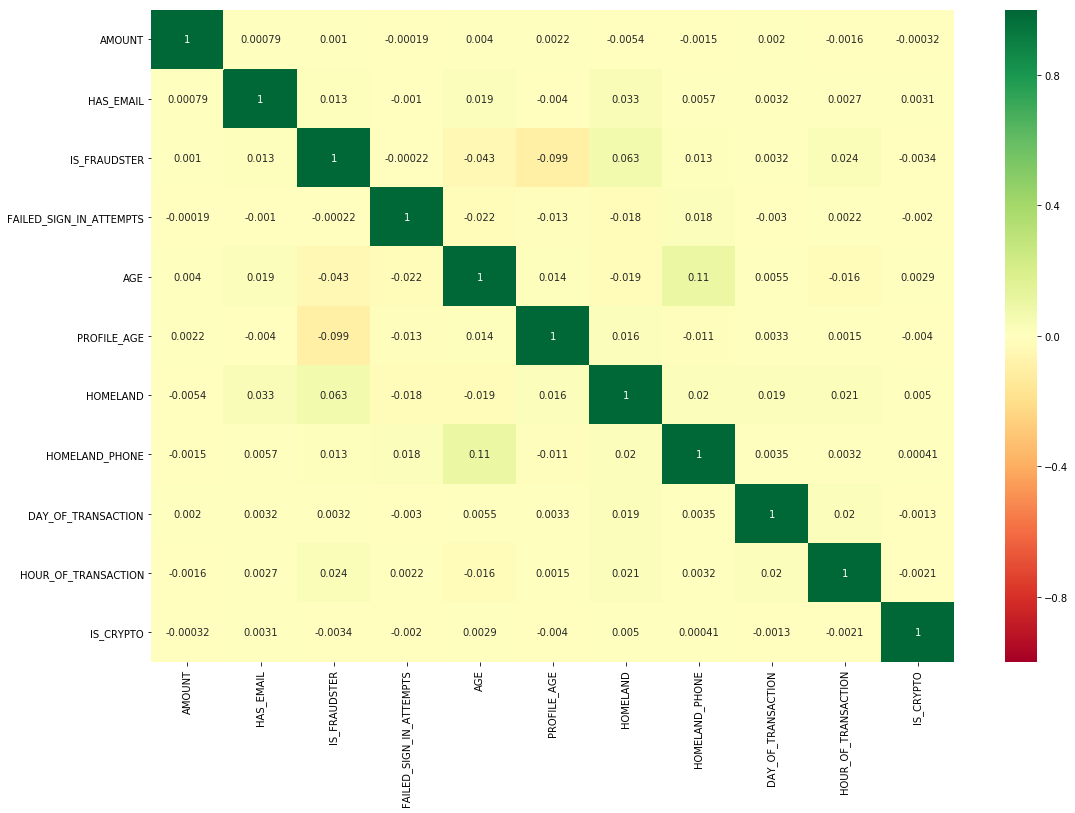

In [ ]:
fig, ax = plt.subplots(figsize=(18,12))
sns.heatmap(df.corr(),annot=True,cmap="RdYlGn",vmin=-1,vmax=1);

In [ ]:
df_f = df[df['IS_FRAUDSTER']==1]
df_nof = df[df['IS_FRAUDSTER']==0]

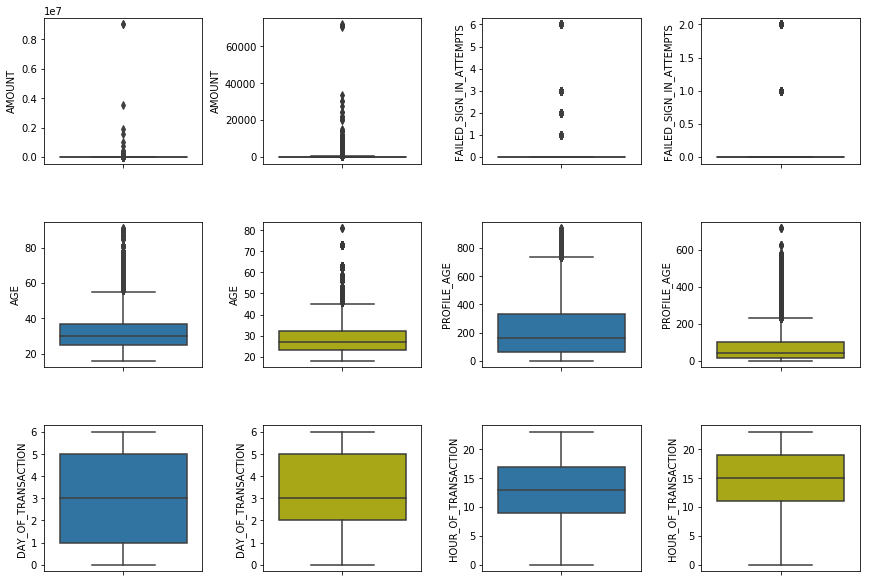

In [ ]:
cols = ['AMOUNT','FAILED_SIGN_IN_ATTEMPTS','AGE','PROFILE_AGE',
        'DAY_OF_TRANSACTION','HOUR_OF_TRANSACTION'
       ]
fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(12, 8))
index = 0
axs = axs.flatten()
for k,v in df[cols].items():
    sns.boxplot(y=k, data=df_nof[cols], ax=axs[index])
    index += 1
    sns.boxplot(y=k, data=df_f[cols], ax=axs[index], color='y')
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

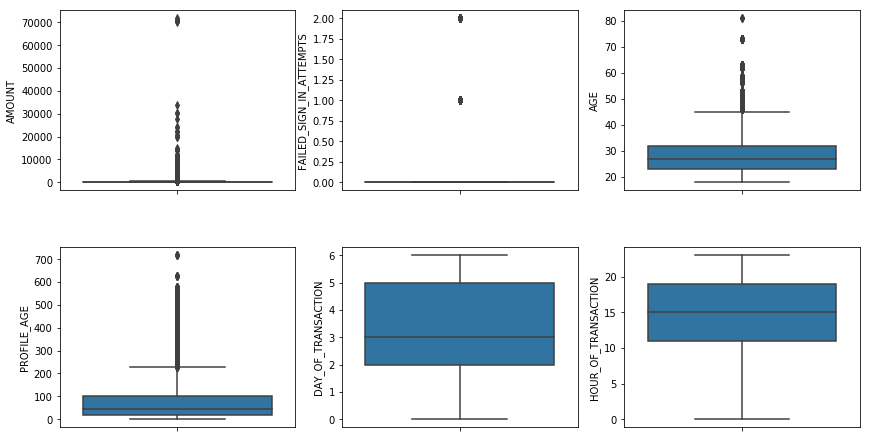

In [ ]:
cols = ['AMOUNT','FAILED_SIGN_IN_ATTEMPTS','AGE','PROFILE_AGE',
        'DAY_OF_TRANSACTION','HOUR_OF_TRANSACTION'
       ]
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(12, 6))
index = 0
axs = axs.flatten()
for k,v in df_f[cols].items():
    sns.boxplot(y=k, data=df_f[cols], ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

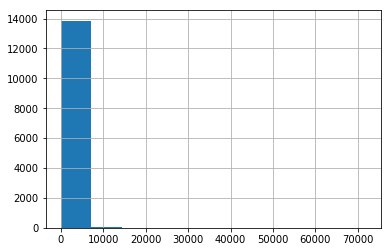

In [ ]:
df[df['IS_FRAUDSTER']==1]['AMOUNT'].hist()

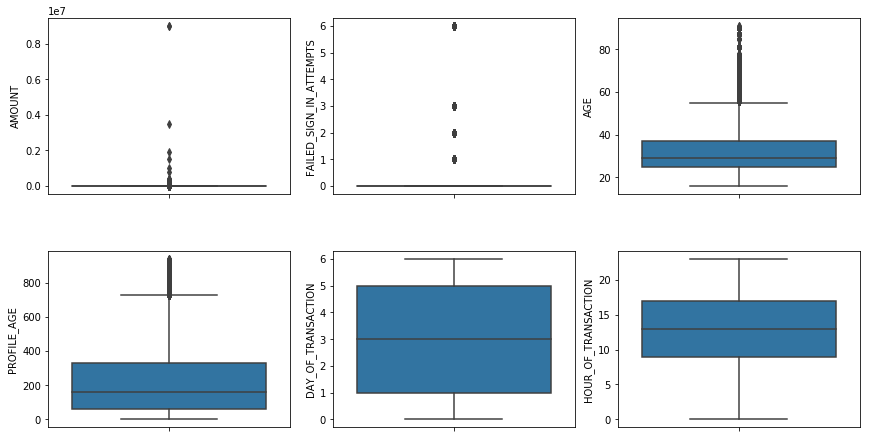

In [ ]:
cols = ['AMOUNT','FAILED_SIGN_IN_ATTEMPTS','AGE','PROFILE_AGE',
        'DAY_OF_TRANSACTION','HOUR_OF_TRANSACTION'
       ]
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(12, 6))
index = 0
axs = axs.flatten()
for k,v in df[cols].items():
    sns.boxplot(y=k, data=df[cols], ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

In [ ]:
# сохраним основной набор данных на диск
df.to_csv(parameters.dataset_file_name, index=False)

Исключим из набора данных пользователей для финального теста и не тренировать на них

In [ ]:
df = pd.read_csv(parameters.dataset_file_name)

In [ ]:
df = df[~df['USER_ID'].isin(test_users)]

#### **Присоединим к набору данных, чтобы получить полный набор данных**

In [ ]:
# Создадим фиктивные столбцы для категориальных переменных
df = pd.get_dummies(df, columns=parameters.cat_features)

### **Теперь у нас есть окончательный набор данных. Посмотрим на них**

In [ ]:
print(df.shape)
print(list(df.columns))
df.head()

(638634, 200)
['TRN_ID', 'USER_ID', 'CREATED_DATE_x', 'AMOUNT', 'HAS_EMAIL', 'IS_FRAUDSTER', 'FAILED_SIGN_IN_ATTEMPTS', 'AGE', 'PROFILE_AGE', 'HOMELAND', 'HOMELAND_PHONE', 'DAY_OF_TRANSACTION', 'HOUR_OF_TRANSACTION', 'IS_CRYPTO', 'ENTRY_METHOD_chip', 'ENTRY_METHOD_cont', 'ENTRY_METHOD_mags', 'ENTRY_METHOD_manu', 'ENTRY_METHOD_mcon', 'ENTRY_METHOD_misc', 'TYPE_ATM', 'TYPE_BANK_TRANSFER', 'TYPE_CARD_PAYMENT', 'TYPE_P2P', 'TYPE_TOPUP', 'SOURCE_APOLLO', 'SOURCE_BRIZO', 'SOURCE_CRONUS', 'SOURCE_GAIA', 'SOURCE_HERA', 'SOURCE_INTERNAL', 'SOURCE_LETO', 'SOURCE_LIMOS', 'SOURCE_MINOS', 'SOURCE_NYX', 'SOURCE_OPHION', 'STATE_CANCELLED', 'STATE_COMPLETED', 'STATE_DECLINED', 'STATE_FAILED', 'STATE_PENDING', 'STATE_RECORDED', 'STATE_REVERTED', 'MERCHANT_CATEGORY_Undefined', 'MERCHANT_CATEGORY_accounting', 'MERCHANT_CATEGORY_administrative_area_level_1', 'MERCHANT_CATEGORY_administrative_area_level_2', 'MERCHANT_CATEGORY_administrative_area_level_3', 'MERCHANT_CATEGORY_administrative_area_level_4', 'M

TRN_ID                               USER_ID  \
0  b3332e6f-7865-4d6e-b6a5-370bc75568d8  8f99c254-7cf2-4e35-b7e4-53804d42445d   
1  bf0e3adf-a932-4e3d-be9c-45d702febf03  8f99c254-7cf2-4e35-b7e4-53804d42445d   
2  f5e63142-4577-482a-884e-b5b8b8526872  8f99c254-7cf2-4e35-b7e4-53804d42445d   
3  839a3fbd-ea6c-4867-ae00-9048d636c261  8f99c254-7cf2-4e35-b7e4-53804d42445d   
4  12974850-86c9-44e8-ac27-af0fca755dbf  8f99c254-7cf2-4e35-b7e4-53804d42445d   

            CREATED_DATE_x  AMOUNT  HAS_EMAIL  IS_FRAUDSTER  \
0  2017-12-20 12:46:20.294    1.75          1             0   
1  2017-12-19 12:40:55.325    1.75          1             0   
2  2017-12-19 12:45:05.706    2.20          1             0   
3  2017-12-21 07:42:25.629    2.10          1             0   
4  2017-12-21 08:36:56.132    4.85          1             0   

   FAILED_SIGN_IN_ATTEMPTS  AGE  PROFILE_AGE  HOMELAND  ...  CURRENCY_PLN  \
0                        0   55           83         1  ...             0   
1                        0   55           82         1  ...             0   
2                        0   55           82         1  ...             0   
3                        0   55           83         1  ...             0   
4                        0   55           83         1  ...             0   

   CURRENCY_QAR  CURRENCY_RON  CURRENCY_SEK  CURRENCY_SGD  CURRENCY_THB  \
0             0             0             0             0             0   
1             0             0             0             0             0   
2             0             0             0             0             0   
3             0             0             0             0             0   
4             0             0             0             0             0   

   CURRENCY_TRY  CURRENCY_USD  CURRENCY_XRP  CURRENCY_ZAR  
0             0             0             0             0  
1             0             0             0             0  
2             0             0             0             0  
3             0             0             0             0  
4             0             0             0             0  

[5 rows x 200 columns]

In [ ]:
# разделить набор данных на функции и прогнозируемые значения
X, y = df, df[parameters.target_feature]
print(list(X.columns))

['TRN_ID', 'USER_ID', 'CREATED_DATE_x', 'AMOUNT', 'HAS_EMAIL', 'IS_FRAUDSTER', 'FAILED_SIGN_IN_ATTEMPTS', 'AGE', 'PROFILE_AGE', 'HOMELAND', 'HOMELAND_PHONE', 'DAY_OF_TRANSACTION', 'HOUR_OF_TRANSACTION', 'IS_CRYPTO', 'ENTRY_METHOD_chip', 'ENTRY_METHOD_cont', 'ENTRY_METHOD_mags', 'ENTRY_METHOD_manu', 'ENTRY_METHOD_mcon', 'ENTRY_METHOD_misc', 'TYPE_ATM', 'TYPE_BANK_TRANSFER', 'TYPE_CARD_PAYMENT', 'TYPE_P2P', 'TYPE_TOPUP', 'SOURCE_APOLLO', 'SOURCE_BRIZO', 'SOURCE_CRONUS', 'SOURCE_GAIA', 'SOURCE_HERA', 'SOURCE_INTERNAL', 'SOURCE_LETO', 'SOURCE_LIMOS', 'SOURCE_MINOS', 'SOURCE_NYX', 'SOURCE_OPHION', 'STATE_CANCELLED', 'STATE_COMPLETED', 'STATE_DECLINED', 'STATE_FAILED', 'STATE_PENDING', 'STATE_RECORDED', 'STATE_REVERTED', 'MERCHANT_CATEGORY_Undefined', 'MERCHANT_CATEGORY_accounting', 'MERCHANT_CATEGORY_administrative_area_level_1', 'MERCHANT_CATEGORY_administrative_area_level_2', 'MERCHANT_CATEGORY_administrative_area_level_3', 'MERCHANT_CATEGORY_administrative_area_level_4', 'MERCHANT_CATEGO

#### **Классы очень несбалансированые**

In [ ]:
df['IS_FRAUDSTER'].value_counts()

0    624720
1     13914
Name: IS_FRAUDSTER, dtype: int64

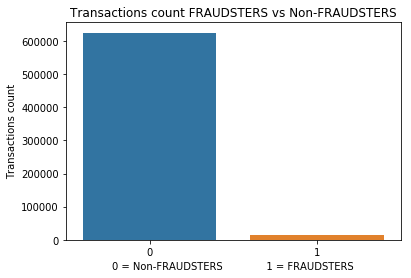

In [ ]:
sns.barplot(x=df['IS_FRAUDSTER'].value_counts().index, y=df['IS_FRAUDSTER'].value_counts())
plt.title('Transactions count FRAUDSTERS vs Non-FRAUDSTERS')
plt.ylabel('Transactions count')
plt.xlabel('0 = Non-FRAUDSTERS              1 = FRAUDSTERS');

#### **Давайте разделим набор данных по времени для обучения и тестирования набора данных перед изменением весов классов**

In [ ]:
def split_dataset(X, y, days=parameters.days_from_max_to_split, random_state=parameters.random_state):
    # Разделим набор данных для обучения и тесторования по min/max date и test_size
    X['CREATED_DATE_x'] = X['CREATED_DATE_x'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f').date())
    max_date = max(X['CREATED_DATE_x'])
    date_test = max_date - timedelta(days = days)
    test_indexes = np.array([t > date_test for t in X['CREATED_DATE_x']])
    X.drop('CREATED_DATE_x', axis=1, inplace=True)
    X_train, y_train, X_test, y_test = X[~test_indexes], y[~test_indexes], X[test_indexes], y[test_indexes]
    return X_train, X_test, y_train, y_test
   
X_train, X_test_over, y_train, y_test_over = split_dataset(X, y, days=parameters.days_from_max_to_split, random_state=parameters.random_state)

In [ ]:
print(X_train.shape, X_test_over.shape, len(y_train), len(y_test_over))

(448752, 199) (189882, 199) 448752 189882


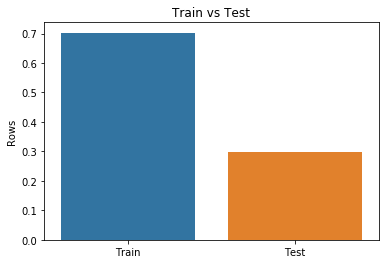

In [ ]:
sns.barplot(x=['Train','Test'], y=[X_train.shape[0]/(X_train.shape[0]+X_test_over.shape[0]),X_test_over.shape[0]/(X_train.shape[0]+X_test_over.shape[0])])
plt.title("Train vs Test")
plt.ylabel('Rows');

In [ ]:
len_train_1 = len(X_train[X_train['IS_FRAUDSTER']==1]['USER_ID'].unique())
len_train_0 = len(X_train[X_train['IS_FRAUDSTER']==0]['USER_ID'].unique())
print(f'There are {len_train_1} fraudsters and {len_train_0} non-fraudsters in TRAIN dataset and proportion is: {len_train_1/(len_train_1+len_train_0)}')

There are 267 fraudsters and 5873 non-fraudsters in TRAIN dataset and proportion is: 0.043485342019543974


In [ ]:
len_test_1 = len(X_test_over[X_test_over['IS_FRAUDSTER']==1]['USER_ID'].unique())
len_test_0 = len(X_test_over[X_test_over['IS_FRAUDSTER']==0]['USER_ID'].unique())
print(f'There are {len_test_1} fraudsters and {len_test_0} non-fraudsters in TEST dataset and proportion is: {len_test_1/(len_test_1+len_test_0)}')

There are 95 fraudsters and 5153 non-fraudsters in TEST dataset and proportion is: 0.018102134146341462


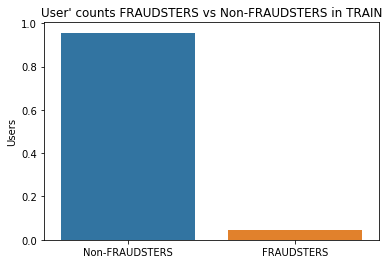

In [ ]:
sns.barplot(x=['Non-FRAUDSTERS','FRAUDSTERS'], y=[len_train_0/(len_train_0+len_train_1),len_train_1/(len_train_0+len_train_1)])
plt.title("User' counts FRAUDSTERS vs Non-FRAUDSTERS in TRAIN")
plt.ylabel('Users');

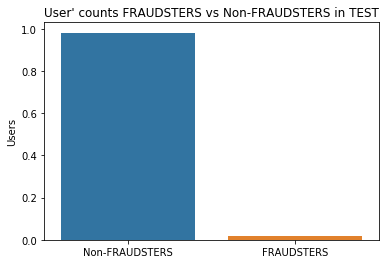

In [ ]:
sns.barplot(x=['Non-FRAUDSTERS','FRAUDSTERS'], y=[len_test_0/(len_test_0+len_test_1),len_test_1/(len_test_0+len_test_1)])
plt.title("User' counts FRAUDSTERS vs Non-FRAUDSTERS in TEST")
plt.ylabel('Users');

In [ ]:
len(X_train[X_train['IS_FRAUDSTER']==1]['TRN_ID'].unique()), len(X_train[X_train['IS_FRAUDSTER']==0]['TRN_ID'].unique())

(11408, 437344)

In [ ]:
y_train.value_counts()

0    437344
1     11408
Name: IS_FRAUDSTER, dtype: int64

In [ ]:
y_test_over.value_counts()

0    187376
1      2506
Name: IS_FRAUDSTER, dtype: int64

In [ ]:
X_train, X_test_over = X_train.drop(parameters.id_features + [parameters.target_feature], axis=1), X_test_over.drop(parameters.id_features + [parameters.target_feature], axis=1)

In [ ]:
X_train.columns

Index(['AMOUNT', 'HAS_EMAIL', 'FAILED_SIGN_IN_ATTEMPTS', 'AGE', 'PROFILE_AGE',
       'HOMELAND', 'HOMELAND_PHONE', 'DAY_OF_TRANSACTION',
       'HOUR_OF_TRANSACTION', 'IS_CRYPTO',
       ...
       'CURRENCY_PLN', 'CURRENCY_QAR', 'CURRENCY_RON', 'CURRENCY_SEK',
       'CURRENCY_SGD', 'CURRENCY_THB', 'CURRENCY_TRY', 'CURRENCY_USD',
       'CURRENCY_XRP', 'CURRENCY_ZAR'],
      dtype='object', length=196)

### **Проверим работоспособность на несбалансированных классах**

### **Логическая регрессия**

In [ ]:
lm = LogisticRegression().fit(X_train,y_train)
y_train_predict = lm.predict(X_train)
roc_auc_train = roc_auc_score(y_train, y_train_predict)
print(f"ROC_AUC on train: {roc_auc_train}")

y_test_predict = lm.predict(X_test_over)

print(f"Test ROC_AUC    : {roc_auc_score(y_test_over, y_test_predict):.5f}")
print(f'Test Accuracy   : {accuracy_score(y_test_over, y_test_predict)}')
print(f'Test F1-score   : {f1_score(y_test_over, y_test_predict, average="macro")}')
print(f'Test Precision  : {precision_score(y_test_over, y_test_predict, average="macro")}')
print(f'Test Recall     : {recall_score(y_test_over, y_test_predict, average="macro")}')

ROC_AUC on train: 0.6969702203283243
Test ROC_AUC    : 0.55351
Test Accuracy   : 0.9875185641608999
Test F1-score   : 0.5896390513343268
Test Precision  : 0.8282579946845106
Test Recall     : 0.5535131404891261


### **Классы балансировки в наборе данных**

In [ ]:
# Используем образец из основного класса с количеством наблюдений во второстепенном классе 
classes_count = y_train.value_counts()
min_class_count = classes_count.min()

X_train_over = []
y_train_over = []

for cls in zip(classes_count,classes_count.index):
    if cls[0] == min_class_count:
        X_minor_class = X_train[y_train==cls[1]]
        y_minor_class = y_train[y_train==cls[1]]
    else:
        X_major_class = X_train[y_train==cls[1]].sample(min_class_count).reset_index(drop=True)
        y_major_class = y_train[y_train==cls[1]].sample(min_class_count).reset_index(drop=True)

del X,y
X_train_over = pd.concat([X_minor_class,X_major_class])
y_train_over = pd.concat([y_minor_class,y_major_class])
df = pd.concat([X_train_over, y_train_over], axis=1)

In [ ]:
df.to_csv(parameters.balanced_dataset_file_name, index=False)

In [ ]:
df['IS_FRAUDSTER'].value_counts()

1    11408
0    11408
Name: IS_FRAUDSTER, dtype: int64

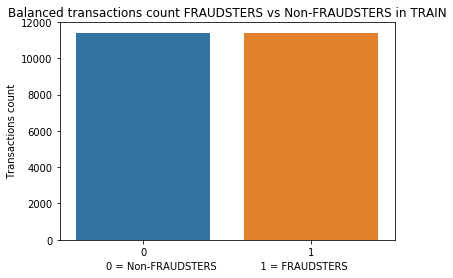

In [ ]:
sns.barplot(x=df['IS_FRAUDSTER'].value_counts().index, y=df['IS_FRAUDSTER'].value_counts())
plt.title('Balanced transactions count FRAUDSTERS vs Non-FRAUDSTERS in TRAIN')
plt.ylabel('Transactions count')
plt.xlabel('0 = Non-FRAUDSTERS              1 = FRAUDSTERS');

### **Проведем статические тесты на сбалансированных классах с очевидными функциями**

#### **Проверим средние значения между группами FRAUDSTERS и NON_FRAUDSTERS**

In [ ]:
# Применим масштабирование для нормализации набора данных
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))
#cols = ['AGE','PROFILE_AGE','AMOUNT','STANDART_PERIOD_HOUR']
cols = ['AGE','PROFILE_AGE','AMOUNT','DAY_OF_TRANSACTION','HOUR_OF_TRANSACTION']
np_scaled = min_max_scaler.fit_transform(X_train_over[cols])
df_norm = pd.DataFrame(np_scaled, columns=cols)
df_norm = pd.concat([df_norm.reset_index(drop=True),y_train_over.reset_index(drop=True)], axis=1)
df_norm.head()

AGE  PROFILE_AGE    AMOUNT  DAY_OF_TRANSACTION  HOUR_OF_TRANSACTION  \
0 -0.459459    -0.944509 -0.998000            0.000000             0.304348   
1 -0.459459    -0.944509 -0.999981            0.000000             0.391304   
2 -0.459459    -0.946821 -0.993000           -0.333333             0.826087   
3 -0.459459    -0.942197 -0.999800            0.333333             0.130435   
4 -0.459459    -0.942197 -0.998000            0.333333             0.826087   

   IS_FRAUDSTER  
0             1  
1             1  
2             1  
3             1  
4             1

In [ ]:
# Разделим набор данных на набор данных мошенников и набор без мошенников
df_fraud = df_norm[df_norm['IS_FRAUDSTER'] == 1]
df_nonfraud = df_norm[df_norm['IS_FRAUDSTER'] == 0]

In [ ]:
def test_avg_diff(df1, df2, field_name, p_value_significance = .05):
    print(f'Check that average {field_name} differ between datasets...')
    p_val = sts.ttest_ind(df1[field_name], df2[field_name])[1]
    if p_val < p_value_significance:
        print(f'p-value ({p_val}) less than the level of significance ({p_value_significance}), \
which means that we can reject the null hypothesis about the same average, \
which means that the average {field_name} in datasets is different.')
    else:
        print(f'p-value ({p_val}) greater than the level of significance ({p_value_significance}), \
which means that we can''t reject the null hypothesis about the same average, \
which means that the average {field_name} in datasets is not different.')
    print('*'*80)

In [ ]:
for c in cols:
    test_avg_diff(df_fraud, df_nonfraud, c)

Check that average AGE differ between datasets...
p-value (5.5210213965886706e-123) less than the level of significance (0.05), which means that we can reject the null hypothesis about the same average, which means that the average AGE in datasets is different.
********************************************************************************
Check that average PROFILE_AGE differ between datasets...
p-value (0.0) less than the level of significance (0.05), which means that we can reject the null hypothesis about the same average, which means that the average PROFILE_AGE in datasets is different.
********************************************************************************
Check that average AMOUNT differ between datasets...
p-value (2.7314103968439252e-05) less than the level of significance (0.05), which means that we can reject the null hypothesis about the same average, which means that the average AMOUNT in datasets is different.
***************************************************

In [ ]:
g=sns.pairplot(data=df_norm,plot_kws={'alpha':0.2},hue='IS_FRAUDSTER');
g.fig.set_size_inches(12,10)
del df_norm

### **Выбор / проверка модели**
#### Давайте создадим модель машинного обучения, которая идентифицирует мошенников. 

Мы можем разделить задачу на две:

* Решите бинарную классификацию: мошенник или нет
* Используйте вероятности двоичного классификатора или решите задачу мультиклассовой классификации с классами: 'PASS', 'LOCK_USER', 'ALERT_AGENT', 'LOCK_USER + ALERT_AGENT'

In [ ]:
y_train_over.value_counts()

In [ ]:
X_train_over.shape

### **Базовая модель - логистическая регрессия**

In [ ]:
lm = LogisticRegression().fit(X_train_over,y_train_over)
y_train_predict = lm.predict(X_train_over)
roc_auc_train = roc_auc_score(y_train_over, y_train_predict)
print(f"ROC_AUC on train: {roc_auc_train}")

y_test_predict = lm.predict(X_test_over)

print(f"Test ROC_AUC    : {roc_auc_score(y_test_over, y_test_predict):.5f}")
print(f'Test Accuracy   : {accuracy_score(y_test_over, y_test_predict)}')
print(f'Test F1-score   : {f1_score(y_test_over, y_test_predict, average="macro")}')
print(f'Test Precision  : {precision_score(y_test_over, y_test_predict, average="macro")}')
print(f'Test Recall     : {recall_score(y_test_over, y_test_predict, average="macro")}')

### **С базовой моделью мы можем увидеть улучшения, если у нас есть сбалансированные классы!**

### **Random Forest**

In [ ]:
# обучим с KFold
rf = RandomForestClassifier(n_jobs=-1,random_state=parameters.random_state)
print(rf)

score_on_train = 0
for trn_idx,tst_idx in KFold(n_splits=parameters.n_folds,random_state=parameters.random_state).split(X_train_over,y_train_over):
    X_train_fold,y_train_fold = X_train_over.iloc[trn_idx],y_train_over.iloc[trn_idx]
    X_test_fold,y_test_fold = X_train_over.iloc[tst_idx],y_train_over.iloc[tst_idx]
    rf.fit(X_train_fold,y_train_fold)
    score_on_train += rf.score(X_test_fold,y_test_fold)

rf.fit(X_train_over,y_train_over)
print(f'Score on train by {parameters.n_folds} folds : {score_on_train/parameters.n_folds}')
print(f'Score on test : {rf.score(X_test_over,y_test_over)}')

rf_pred = rf.predict(X_test_over)
print (f"Test ROC_AUC   : {roc_auc_score(y_test_over, rf_pred):.5f}")
print (f"Test Accuracy  : {accuracy_score(y_test_over,rf_pred):.5f}")
print (f"Test F1-score  : {f1_score(y_test_over,rf_pred,average='macro'):.5f}")
print (f"Test Precision : {precision_score(y_test_over,rf_pred,average='macro'):.5f}")
print (f"Test Recall    : {recall_score(y_test_over,rf_pred,average='macro'):.5f}")

In [ ]:
%%time
params = {'n_estimators':[10,20,50,100],
          'max_depth':[5,10,15,20,25,30],
          'min_samples_leaf':[1,5,10],
          'min_samples_split' : [2,10,100],
          'random_state':[parameters.random_state],
          'n_jobs':[-1]
         }

rf_grid = GridSearchCV(RandomForestClassifier(),param_grid=params,verbose=0,n_jobs=-1,cv=parameters.n_folds)
rf_grid.fit(X_train_over,y_train_over)
print(rf_grid.best_params_)
rf = rf_grid.best_estimator_

rf_pred = rf.predict(X_test_over)
print (f"Test ROC_AUC   : {roc_auc_score(y_test_over, rf_pred):.5f}")
print (f"Test Accuracy  : {accuracy_score(y_test_over,rf_pred):.5f}")
print (f"Test F1-score  : {f1_score(y_test_over,rf_pred,average='macro'):.5f}")
print (f"Test Precision : {precision_score(y_test_over,rf_pred,average='macro'):.5f}")
print (f"Test Recall    : {recall_score(y_test_over,rf_pred,average='macro'):.5f}")

{'max_depth': 20, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 10, 'n_jobs': -1, 'random_state': 7}
Test ROC_AUC   : 0.88081
Test Accuracy  : 0.94271
Test F1-score  : 0.62185
Test Precision : 0.58083
Test Recall    : 0.88081
CPU times: user 8.91 s, sys: 1.42 s, total: 10.3 s
Wall time: 2min 35s


In [ ]:
# сохранить список функций в параметре модели
rf.feature_names = list(X_train_over.columns.values)
# сохранить модель в артефакт
#joblib.dump(rf, parameters.model_pkl)
pickle.dump(rf, open(parameters.model_pkl, 'wb'))
#rf = joblib.load(model_pkl)

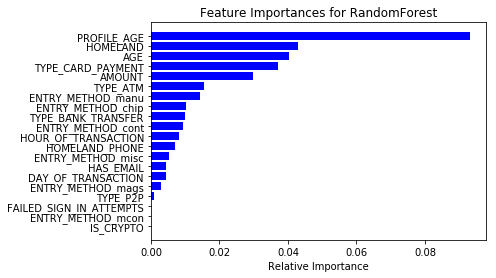

In [ ]:
# Посмотрим на важность функций
features = X_train_over.columns
importances = rf.feature_importances_[0:20]
indices = np.argsort(importances)

plt.title('Feature Importances for RandomForest')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()
del rf

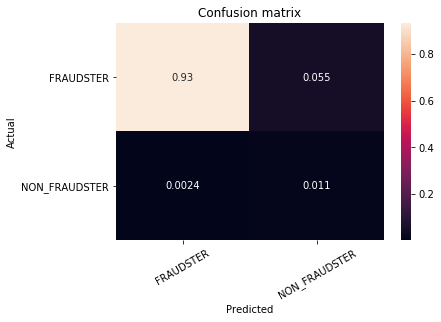

In [ ]:
df_conf = pd.DataFrame({'y_Actual': y_test_over, 'y_Predicted': rf_pred}, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df_conf['y_Actual'], df_conf['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
confusion_matrix_gr = confusion_matrix/sum(sum(confusion_matrix.values))
class_names = ['FRAUDSTER','NON_FRAUDSTER']
ax=sns.heatmap(confusion_matrix_gr, annot=True);
ax.set_title('Confusion matrix')
ax.set_yticklabels(class_names, rotation=0);
ax.set_xticklabels(class_names, rotation=30);

In [ ]:
confusion_matrix

Predicted       0      1
Actual                  
0          176955  10421
1             458   2048

Из-за min_samples_leaf = 1 мы можем подумать, что классификатор переоснащен в наборе данных. Но точность TEST и оценка F1 очень хороши для RandomForest только с 10 деревьями.

Сделаем поиск по сетке параметров для randomforest

In [ ]:
%%time
params = {'n_estimators':[10,20],
          'max_depth':[5,10,20],
          'min_samples_leaf':[1,5,10],
          'random_state':[parameters.random_state],
          'n_jobs':[-1]}

rf_grid = GridSearchCV(RandomForestClassifier(),param_grid=params,verbose=0,n_jobs=-1,cv=parameters.n_folds)
rf_grid.fit(X_train_over,y_train_over)
print(rf_grid.best_params_)

{'max_depth': 20, 'min_samples_leaf': 5, 'n_estimators': 10, 'n_jobs': -1, 'random_state': 7}
CPU times: user 1.2 s, sys: 116 ms, total: 1.32 s
Wall time: 5.2 s


In [ ]:
rf_pred = rf_grid.predict(X_test_over)
print (f"Test ROC_AUC   : {roc_auc_score(y_test_over, rf_pred):.5f}")
print (f"Test Accuracy  : {accuracy_score(y_test_over,rf_pred):.5f}")
print (f"Test F1-score  : {f1_score(y_test_over,rf_pred,average='macro'):.5f}")
print (f"Test Precision : {precision_score(y_test_over,rf_pred,average='macro'):.5f}")
print (f"Test Recall    : {recall_score(y_test_over,rf_pred,average='macro'):.5f}")

Test ROC_AUC   : 0.88081
Test Accuracy  : 0.94271
Test F1-score  : 0.62185
Test Precision : 0.58083
Test Recall    : 0.88081


У нас нет улучшений TEST после gridsearch на RF.

### XGBoost

In [ ]:
%%time
params = {'n_estimators':[50,100,200],
          'max_depth':range(5,13),
          'random_state':[parameters.random_state],
          'n_jobs':[-1]}

rf_grid = GridSearchCV(XGBClassifier(), param_grid=params, verbose=0, n_jobs=-1, cv=parameters.n_folds)
rf_grid.fit(X_train_over,y_train_over)
print(rf_grid.best_params_)

rf_pred = rf_grid.predict(X_test_over)
print (f"Test ROC_AUC   : {roc_auc_score(y_test_over, rf_pred):.5f}")
print (f"Test Accuracy  : {accuracy_score(y_test_over,rf_pred):.5f}")
print (f"Test F1-score  : {f1_score(y_test_over,rf_pred,average='macro'):.5f}")
print (f"Test Precision : {precision_score(y_test_over,rf_pred,average='macro'):.5f}")
print (f"Test Recall    : {recall_score(y_test_over,rf_pred,average='macro'):.5f}")

{'max_depth': 7, 'n_estimators': 50, 'n_jobs': -1, 'random_state': 7}
Test ROC_AUC   : 0.88361
Test Accuracy  : 0.96143
Test F1-score  : 0.66749
Test Precision : 0.61249
Test Recall    : 0.88361
CPU times: user 23.7 s, sys: 696 ms, total: 24.4 s
Wall time: 10min 47s


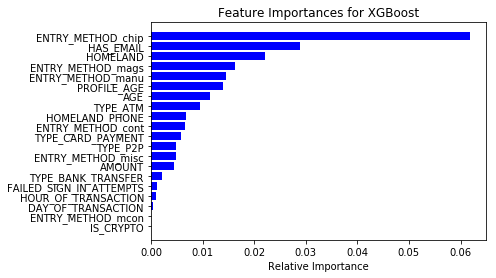

In [ ]:
# Посмотрим на важность функций
features = X_train_over.columns
rf = rf_grid.best_estimator_
importances = rf.feature_importances_[0:20]
indices = np.argsort(importances)

plt.title('Feature Importances for XGBoost')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()
del rf

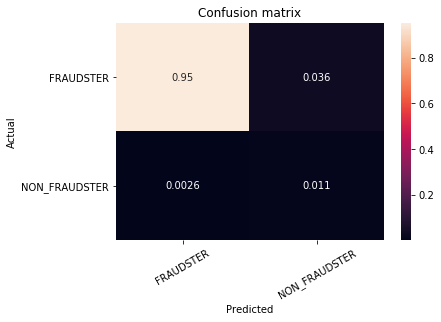

In [ ]:
df_conf = pd.DataFrame({'y_Actual': y_test_over, 'y_Predicted': rf_pred}, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df_conf['y_Actual'], df_conf['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
confusion_matrix_gr = confusion_matrix/sum(sum(confusion_matrix.values))
class_names = ['FRAUDSTER','NON_FRAUDSTER']
ax=sns.heatmap(confusion_matrix_gr, annot=True);
ax.set_title('Confusion matrix')
ax.set_yticklabels(class_names, rotation=0);
ax.set_xticklabels(class_names, rotation=30);

In [ ]:
confusion_matrix

Predicted       0     1
Actual                 
0          180545  6831
1             492  2014

## **Давайте попробуем PCA, чтобы минимизировать количество функций для модели.**

In [ ]:
print(f'Current shape of the dataset: {X_train_over.shape}')

Current shape of the dataset: (22816, 196)


### **Проверим RF с помощью PCA**

In [ ]:
l_result = []
for n in range(1,df.shape[1]//4):
    pca = PCA(n_components=n, random_state=parameters.random_state)
    pc = pca.fit_transform(X_train_over)
    df_pc = pd.DataFrame(data = pc, columns = ['pc'+str(i) for i in range(n)])
    X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(df_pc, y_train_over, stratify=y_train_over, test_size=parameters.test_size, random_state=parameters.random_state)
    
    rf_pca = RandomForestClassifier(n_jobs=-1, random_state=parameters.random_state)
    score_on_train = 0
    for trn_idx,tst_idx in KFold(n_splits=parameters.n_folds,random_state=parameters.random_state).split(X_train_pca,y_train_pca):
        X_train_fold,y_train_fold = X_train_pca.iloc[trn_idx],y_train_pca.iloc[trn_idx]
        X_test_fold,y_test_fold = X_train_pca.iloc[tst_idx],y_train_pca.iloc[tst_idx]
        rf_pca.fit(X_train_fold, y_train_fold)
        score_on_train += rf_pca.score(X_test_fold, y_test_fold)

    rf_pca.fit(X_train_pca,y_train_pca)
    print(f'Components={n}; Accuracy on train by {parameters.n_folds} folds : {score_on_train/parameters.n_folds}')
    print(f'Components={n}; Accuracy on test : {rf_pca.score(X_test_pca,y_test_pca)}')
    y_test_predict_proba = rf_pca.predict_proba(X_test_pca)[:, 1]
    y_test_predict = rf_pca.predict(X_test_pca)
    l_result.append((n,
                     roc_auc_score(y_test_pca, y_test_predict_proba),
                     accuracy_score(y_test_pca, y_test_predict),
                     f1_score(y_test_pca, y_test_predict, average="macro")
                    ))

Components=1; Accuracy on train by 3 folds : 0.6312693842065057
Components=1; Accuracy on test : 0.6362308254200146
Components=2; Accuracy on train by 3 folds : 0.6982654785833878
Components=2; Accuracy on test : 0.7095690284879475
Components=3; Accuracy on train by 3 folds : 0.8053967164687367
Components=3; Accuracy on test : 0.8154857560262966
Components=4; Accuracy on train by 3 folds : 0.8107194706084137
Components=4; Accuracy on test : 0.8179693206720233
Components=5; Accuracy on train by 3 folds : 0.8066493782868847
Components=5; Accuracy on test : 0.8189919649379109
Components=6; Accuracy on train by 3 folds : 0.8360782153100068
Components=6; Accuracy on test : 0.8582907231555881
Components=7; Accuracy on train by 3 folds : 0.9128420137269151
Components=7; Accuracy on test : 0.9161431701972242
Components=8; Accuracy on train by 3 folds : 0.9172250362613251
Components=8; Accuracy on test : 0.9215485756026297
Components=9; Accuracy on train by 3 folds : 0.9244882988212653
Componen

In [ ]:
# Сортируем по ROC_AUC и F1-score в Test
#l_result.sort(key=lambda x:x[1]*10+x[3],reverse=True)
l_result.sort(key=lambda x:x[3],reverse=True)
l_result

[(10, 0.9817445775842006, 0.9425858290723156, 0.942583868391017),
 (30, 0.9798153942978303, 0.9415631848064281, 0.941561826563014),
 (44, 0.9794708774640146, 0.9414170927684441, 0.9414146720330869),
 (40, 0.9782906586635973, 0.9412710007304602, 0.9412697961439618),
 (19, 0.9815155257529214, 0.9411249086924762, 0.9411224758836261),
 (11, 0.9805932143629755, 0.9409788166544923, 0.9409755400390819),
 (17, 0.9815602604378227, 0.9405405405405406, 0.9405388958239764),
 (37, 0.9806408516801034, 0.9402483564645727, 0.9402463159590992),
 (27, 0.9810420125281022, 0.9398100803506209, 0.9398081263703644),
 (31, 0.9796008983134512, 0.939517896274653, 0.9395169552212507),
 (35, 0.9781364776694527, 0.9393718042366691, 0.9393692989868605),
 (42, 0.9788323410599696, 0.9392257121986852, 0.9392237392477465),
 (18, 0.9798917591368459, 0.9392257121986852, 0.9392233137688206),
 (38, 0.980530124797819, 0.9389335281227174, 0.9389317438055167),
 (24, 0.9801873580804927, 0.9389335281227174, 0.9389261959853485),

In [ ]:
print(f'Best n_components by PCA: {l_result[0][0]}')

Best n_components by PCA: 10


In [ ]:
parameters.best_pca_components_number = l_result[0][0]
parameters.best_pca = PCA(n_components=parameters.best_pca_components_number, random_state=parameters.random_state)
parameters.best_pca.fit(X_train_over);

In [ ]:
ds_pc = parameters.best_pca.transform(X_train_over)
df_pc = pd.DataFrame(data = ds_pc, columns = ['pc'+str(i) for i in range(parameters.best_pca_components_number)])
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(df_pc, y_train_over, stratify=y_train_over, test_size=parameters.test_size, random_state=parameters.random_state)

In [ ]:
%%time
params = {'n_estimators':[10,20],
          'max_depth':[5,10,20],
          'min_samples_leaf':[1,5,10],
          'random_state':[parameters.random_state],
          'n_jobs':[-1]}

rf_grid = GridSearchCV(RandomForestClassifier(),param_grid=params,verbose=0,n_jobs=-1,cv=parameters.n_folds)
rf_grid.fit(X_train_pca,y_train_pca)
print(rf_grid.best_params_)

{'max_depth': 20, 'min_samples_leaf': 1, 'n_estimators': 20, 'n_jobs': -1, 'random_state': 7}
CPU times: user 2.12 s, sys: 257 ms, total: 2.37 s
Wall time: 5.75 s


In [ ]:
rf_pca = rf_grid.best_estimator_
rf_pca.fit(X_train_pca,y_train_pca)
rf_pred = rf_pca.predict(X_test_pca)
y_pred_proba = rf_pca.predict_proba(X_test_pca)[::,1]

print (f"Test ROC_AUC   : {roc_auc_score(y_test_pca, y_pred_proba):.5f}")
print (f"Test Accuracy  : {accuracy_score(y_test_pca,rf_pred):.5f}")
print (f"Test F1-score  : {f1_score(y_test_pca,rf_pred,average='macro'):.5f}")
print (f"Test Precision : {precision_score(y_test_pca,rf_pred,average='macro'):.5f}")
print (f"Test Recall    : {recall_score(y_test_pca,rf_pred,average='macro'):.5f}")

Test ROC_AUC   : 0.98374
Test Accuracy  : 0.94463
Test F1-score  : 0.94463
Test Precision : 0.94481
Test Recall    : 0.94463


### **Проверим XGBoost с помощью PCA**

In [ ]:
l_result = []
for n in range(1,df.shape[1]//4):
    pca = PCA(n_components=n, random_state=parameters.random_state)
    pc = pca.fit_transform(X_train_over)
    df_pc = pd.DataFrame(data = pc, columns = ['pc'+str(i) for i in range(n)])
    X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(df_pc, y_train_over, stratify=y_train_over, test_size=parameters.test_size, random_state=parameters.random_state)
    
    rf_pca = XGBClassifier(n_jobs=-1, random_state=parameters.random_state)
    score_on_train = 0
    for trn_idx,tst_idx in KFold(n_splits=parameters.n_folds,random_state=parameters.random_state).split(X_train_pca,y_train_pca):
        X_train_fold,y_train_fold = X_train_pca.iloc[trn_idx],y_train_pca.iloc[trn_idx]
        X_test_fold,y_test_fold = X_train_pca.iloc[tst_idx],y_train_pca.iloc[tst_idx]
        rf_pca.fit(X_train_fold, y_train_fold)
        score_on_train += rf_pca.score(X_test_fold, y_test_fold)

    rf_pca.fit(X_train_pca,y_train_pca)
    print(f'Components={n}; Accuracy on train by {parameters.n_folds} folds : {score_on_train/parameters.n_folds}')
    print(f'Components={n}; Accuracy on test : {rf_pca.score(X_test_pca,y_test_pca)}')
    y_test_predict_proba = rf_pca.predict_proba(X_test_pca)[:, 1]
    y_test_predict = rf_pca.predict(X_test_pca)
    l_result.append((n,
                     roc_auc_score(y_test_pca, y_test_predict_proba),
                     accuracy_score(y_test_pca, y_test_predict),
                     f1_score(y_test_pca, y_test_predict, average="macro")))

Components=1; Accuracy on train by 3 folds : 0.6543107163066081
Components=1; Accuracy on test : 0.6420745069393718
Components=2; Accuracy on train by 3 folds : 0.7105378122968248
Components=2; Accuracy on test : 0.706208911614317
Components=3; Accuracy on train by 3 folds : 0.7812912569756797
Components=3; Accuracy on test : 0.775018261504748
Components=4; Accuracy on train by 3 folds : 0.7821678732446444
Components=4; Accuracy on test : 0.7739956172388605
Components=5; Accuracy on train by 3 folds : 0.7790369479484082
Components=5; Accuracy on test : 0.7739956172388605
Components=6; Accuracy on train by 3 folds : 0.7908082404587513
Components=6; Accuracy on test : 0.7899196493791089
Components=7; Accuracy on train by 3 folds : 0.8860436724252412
Components=7; Accuracy on test : 0.8772826880934989
Components=8; Accuracy on train by 3 folds : 0.8921795981592623
Components=8; Accuracy on test : 0.8819576333089847
Components=9; Accuracy on train by 3 folds : 0.8918040113313083
Components

In [ ]:
# Сортируем по ROC_AUC и F1-score в Test
#l_result.sort(key=lambda x:x[1]*10+x[3],reverse=True)
# Сортировать по F1-score
l_result.sort(key=lambda x:x[3],reverse=True)
l_result

[(41, 0.9764652871650896, 0.9221329437545653, 0.9220882194165694),
 (44, 0.9770412889189625, 0.9219868517165815, 0.9219358269583157),
 (48, 0.9765078021900532, 0.9216946676406136, 0.9216491410901448),
 (46, 0.9767587091345665, 0.9212563915266618, 0.921213344245509),
 (42, 0.9762328204723674, 0.9212563915266618, 0.9212042983360609),
 (38, 0.9761018605360343, 0.920964207450694, 0.9209045423556466),
 (45, 0.977015464029301, 0.9206720233747261, 0.9206253411932469),
 (47, 0.9767164502242113, 0.9206720233747261, 0.9206195435927294),
 (35, 0.9752408885947556, 0.9202337472607743, 0.9201815758787273),
 (39, 0.975627194795478, 0.9202337472607743, 0.9201702825499988),
 (43, 0.9766985648874043, 0.9193571950328707, 0.9193168844928283),
 (29, 0.9753236136132085, 0.9193571950328707, 0.9193056498090215),
 (37, 0.9760318131906878, 0.9193571950328707, 0.9193032370455558),
 (34, 0.9745009308058579, 0.9193571950328707, 0.9192930329076912),
 (36, 0.9756995044865303, 0.9190650109569029, 0.9190032599215896),

In [ ]:
print(f'Best n_components by PCA: {l_result[0][0]}')

Best n_components by PCA: 41


In [ ]:
parameters.best_pca_components_number = l_result[0][0]
parameters.best_pca = PCA(n_components=parameters.best_pca_components_number, random_state=parameters.random_state)
parameters.best_pca.fit(X_train_over);

Видим улучшения в TEST с PCA.

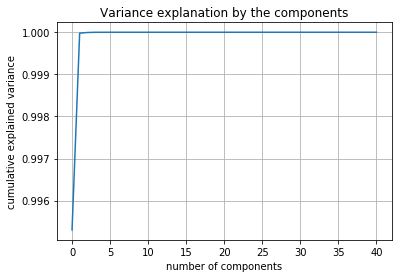

In [ ]:
plt.plot(np.cumsum(parameters.best_pca.explained_variance_ratio_))
plt.title('Variance explanation by the components')
plt.grid()
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

Похоже, для хорошего качества можно использовать даже 4 компонента.

Проверим это:

In [ ]:
test_pca = PCA(n_components=4, random_state=parameters.random_state)
test_ds_pc = test_pca.fit_transform(X_train_over)
test_df_pc = pd.DataFrame(data = test_ds_pc, columns = ['pc'+str(i) for i in range(4)])
X_comp_train_pca, X_comp_test_pca, y_comp_train_pca, y_comp_test_pca = train_test_split(test_df_pc, y_train_over, stratify=y_train_over, test_size=parameters.test_size, random_state=parameters.random_state)

In [ ]:
%%time
params = {'n_estimators':[50,100,200],
          'max_depth':range(5,13),
          'random_state':[parameters.random_state],
          'n_jobs':[-1]}

rf_comp_grid = GridSearchCV(XGBClassifier(), param_grid=params, verbose=0, n_jobs=-1, cv=parameters.n_folds)
rf_comp_grid.fit(X_comp_train_pca,y_comp_train_pca)
print(rf_comp_grid.best_params_)

rf_comp_pred = rf_comp_grid.predict(X_comp_test_pca)
rf_comp_pred_proba = rf_comp_grid.predict_proba(X_comp_test_pca)[::,1]
print (f"Test ROC_AUC   : {roc_auc_score(y_comp_test_pca, rf_comp_pred_proba):.5f}")
print (f"Test Accuracy  : {accuracy_score(y_comp_test_pca,rf_comp_pred):.5f}")
print (f"Test F1-score  : {f1_score(y_comp_test_pca,rf_comp_pred,average='macro'):.5f}")
print (f"Test Precision : {precision_score(y_comp_test_pca,rf_comp_pred,average='macro'):.5f}")
print (f"Test Recall    : {recall_score(y_comp_test_pca,rf_comp_pred,average='macro'):.5f}")

{'max_depth': 11, 'n_estimators': 200, 'n_jobs': -1, 'random_state': 7}
Test ROC_AUC   : 0.91842
Test Accuracy  : 0.83974
Test F1-score  : 0.83947
Test Precision : 0.84201
Test Recall    : 0.83973
CPU times: user 34.7 s, sys: 162 ms, total: 34.9 s
Wall time: 59.2 s


Не все так хорошо.

Вернемся к лучшему номеру компонента:

In [ ]:
ds_pc = parameters.best_pca.transform(X_train_over)
df_pc = pd.DataFrame(data = ds_pc, columns = ['pc'+str(i) for i in range(parameters.best_pca_components_number)])
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(df_pc, y_train_over, stratify=y_train_over, test_size=parameters.test_size, random_state=parameters.random_state)

In [ ]:
%%time
params = {'n_estimators':[50,100,200],
          'max_depth':range(5,13),
          'random_state':[parameters.random_state],
          'n_jobs':[-1]}

rf_grid = GridSearchCV(XGBClassifier(), param_grid=params, verbose=0, n_jobs=-1, cv=parameters.n_folds)
rf_grid.fit(X_train_pca,y_train_pca)
print(rf_grid.best_params_)

{'max_depth': 9, 'n_estimators': 200, 'n_jobs': -1, 'random_state': 7}
CPU times: user 2min 12s, sys: 418 ms, total: 2min 12s
Wall time: 6min 29s


In [ ]:
rf_pca = rf_grid.best_estimator_
rf_pca.fit(X_train_pca,y_train_pca)
rf_pred = rf_pca.predict(X_test_pca)
y_pred_proba = rf_pca.predict_proba(X_test_pca)[::,1]

print (f"Test ROC_AUC   : {roc_auc_score(y_test_pca, y_pred_proba):.5f}")
print (f"Test Accuracy  : {accuracy_score(y_test_pca,rf_pred):.5f}")
print (f"Test F1-score  : {f1_score(y_test_pca,rf_pred,average='macro'):.5f}")
print (f"Test Precision : {precision_score(y_test_pca,rf_pred,average='macro'):.5f}")
print (f"Test Recall    : {recall_score(y_test_pca,rf_pred,average='macro'):.5f}")

Test ROC_AUC   : 0.99180
Test Accuracy  : 0.95690
Test F1-score  : 0.95689
Test Precision : 0.95746
Test Recall    : 0.95690


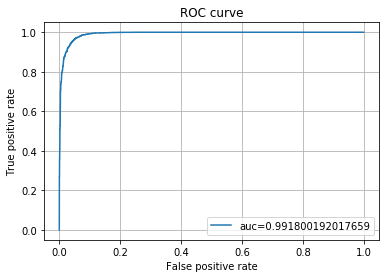

In [ ]:
fpr, tpr, _ = roc_curve(y_test_pca,  y_pred_proba)
auc = roc_auc_score(y_test_pca, y_pred_proba)
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.title('ROC curve')
plt.legend(loc=4)
plt.grid()
plt.xlabel('False positive rate')
plt.ylabel('True positive rate');

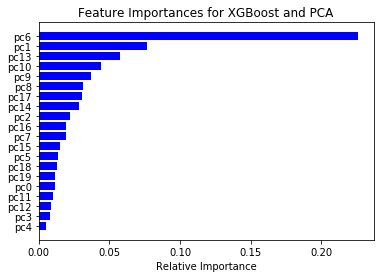

In [ ]:
# Посмотрим на важность функций
features = list(X_train_pca.columns.values)
importances = rf_pca.feature_importances_[0:20]
indices = np.argsort(importances)

plt.title('Feature Importances for XGBoost and PCA')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

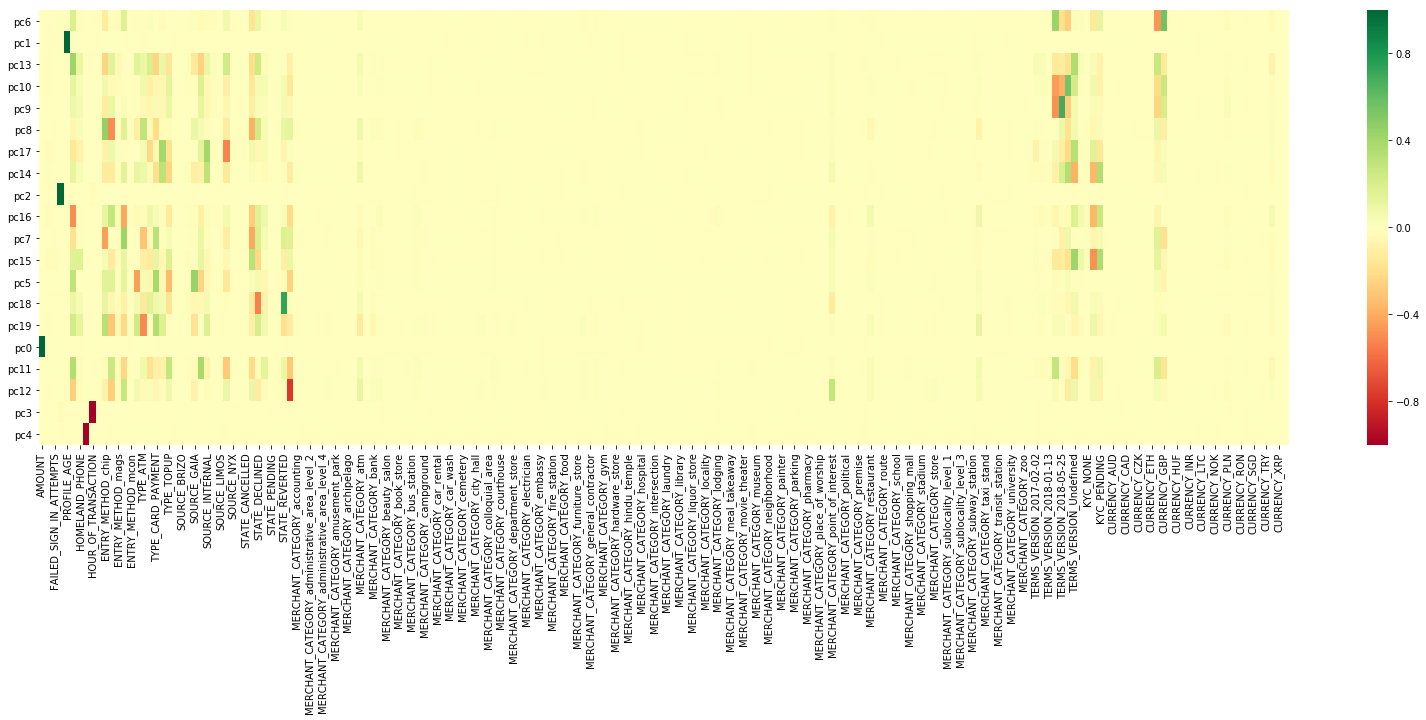

In [ ]:
fig, ax = plt.subplots(figsize=(28,8))
sns.heatmap(pd.DataFrame(parameters.best_pca.components_,columns=X_train_over.columns,index = features).loc[[features[i] for i in indices[::-1]]],cmap="RdYlGn",vmin=-1,vmax=1);

Проверим самую важную функцию PC6

In [ ]:
pcs = pd.DataFrame(parameters.best_pca.components_,columns=X_train_over.columns,index = features).loc['pc6']

Посмотрим на настоящие функции внутри PC6

In [ ]:
pcs.sort_values()

CURRENCY_EUR               -0.470389
TERMS_VERSION_2018-09-20   -0.259930
TERMS_VERSION_2018-05-25   -0.191110
STATE_COMPLETED            -0.166100
KYC_PASSED                 -0.135404
                              ...   
KYC_PENDING                 0.119044
ENTRY_METHOD_manu           0.166564
HOMELAND                    0.193090
TERMS_VERSION_2018-03-20    0.437195
CURRENCY_GBP                0.559896
Name: pc6, Length: 196, dtype: float64

Видим, что внутри PC6 есть другие наиболее взвешенные функции, чем FeatureImportance of RF с реальными функциями, но есть некоторые общие.

Хорошо, сохраните список функций в параметре модели и сохраните модель в артефакте

In [ ]:
pickle.dump(rf_pca, open(parameters.model_pkl, 'wb'))

## **Operationalization**
- Как использовать эту модель для поимки мошенников? Если мошенник обнаружен, какое действие должно произойти: LOCK_USER, ALERT_AGENT или BOTH?
- Сделаем патрульную функцию, реализующую эту логику. Функция должна принимать user_id и выдавать предлагаемые действия (например, patrol (user_id) = ['LOCK_USER', 'ALERT_AGENT'])

**Теперь мы можем:**

* проверить, является ли отдельная транзакция мошеннической.
* проверить всего пользователя на все его транзакции

В бинарной классификации мы могли бы использовать прогноз-вероятность, чтобы предсказать процент вероятности того, что это мошенник. Думаю, было бы полезно работать с тремя уровнями внимания:

* Если процент больше первого уровня (например, 50%), нам нужен ALERT.
* Если процент больше второго уровня (например, 75%), нам нужны БЛОКИРОВКА и ТРЕВОГА.
* Если процент больше максимального уровня (например, 90%), нам нужна БЛОКИРОВКА.

In [ ]:
# загружаем нашу предварительно обученную модель
#rf = joblib.load(parameters.model_pkl)
rf = pickle.load(open(parameters.model_pkl,'rb'))
print('Pretrained model: ', rf)
#print('\nFeatures of this model: ', rf.feature_names)
print('\nFeatures of this model: ', list(X_train_pca.columns.values))

Pretrained model:  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=9, min_child_weight=1, missing=nan, n_estimators=200,
              n_jobs=-1, nthread=None, objective='binary:logistic',
              random_state=7, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)

Features of this model:  ['pc0', 'pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6', 'pc7', 'pc8', 'pc9', 'pc10', 'pc11', 'pc12', 'pc13', 'pc14', 'pc15', 'pc16', 'pc17', 'pc18', 'pc19', 'pc20', 'pc21', 'pc22', 'pc23', 'pc24', 'pc25', 'pc26', 'pc27', 'pc28', 'pc29', 'pc30', 'pc31', 'pc32', 'pc33', 'pc34', 'pc35', 'pc36', 'pc37', 'pc38', 'pc39', 'pc40']


In [ ]:
# Посмотрим на мошенников
user_df = pd.read_csv(parameters.user_dataset)
user_df[user_df['IS_FRAUDSTER']==True].head()

ID  HAS_EMAIL   PHONE_COUNTRY  \
8166  5270b0f4-2e4a-4ec9-8648-2135312ac1c4          1  GB||JE||IM||GG   
8167  848fc1b1-096c-40f7-b04a-1399c469e421          1              PL   
8168  27c76eda-e159-4df3-845a-e13f4e28a8b5          1  GB||JE||IM||GG   
8169  a27088ef-9452-403d-9bbb-f7b10180cdda          1              IN   
8170  fb23710b-609a-49bf-8a9a-be49c59ce6de          1              LT   

      IS_FRAUDSTER TERMS_VERSION                CREATED_DATE   STATE COUNTRY  \
8166          True           NaN  2017-09-19 01:55:22.376000  LOCKED      GB   
8167          True    2018-05-25  2018-06-16 15:55:43.800000  LOCKED      GB   
8168          True    2018-05-25  2018-05-11 18:20:45.608000  LOCKED      GB   
8169          True    2018-05-25  2018-05-18 16:41:12.267000  LOCKED      BE   
8170          True    2018-03-20  2018-03-29 13:37:29.736000  LOCKED      LT   

      BIRTH_YEAR     KYC  FAILED_SIGN_IN_ATTEMPTS  
8166        1988    NONE                        0  
8167        1994  PASSED                        0  
8168        1997  PASSED                        0  
8169        1989  PASSED                        0  
8170        1992  PASSED                        0

In [ ]:
# Тестовое предсказание на основе полных наборов данных из файла
# загружаем данные из файла
df = pd.read_csv(parameters.dataset_file_name)[parameters.cols_to_select]

In [ ]:
# Создадим фиктивные столбцы для категориальных переменных
df = pd.get_dummies(df, columns=parameters.cat_features)

In [ ]:
ds_pc = parameters.best_pca.transform(df.drop(parameters.id_features + [parameters.target_feature] + ['CREATED_DATE_x'], axis=1))
df = pd.concat([pd.DataFrame(data = ds_pc, columns = ['pc'+str(i) for i in range(parameters.best_pca_components_number)]), df[parameters.id_features + [parameters.target_feature]]], axis=1)

In [ ]:
df.head()

pc0        pc1        pc2       pc3       pc4       pc5       pc6  \
0 -216.929639 -68.549575  24.763310  1.292724  0.112950  1.247565  0.274153   
1 -216.928474 -69.549775  24.768030  1.288133  1.112665  1.247515  0.272426   
2 -216.478474 -69.549269  24.768076  1.287606  1.112668  1.240087  0.272905   
3 -216.579670 -68.544937  24.854563  6.298272 -0.859248  0.965408  0.281030   
4 -213.829671 -68.542362  24.834123  5.297288 -0.865640  1.233410  0.290514   

        pc7       pc8       pc9  ...      pc34      pc35      pc36      pc37  \
0 -0.310793 -0.866494  0.962703  ... -0.049566 -0.010845 -0.424098 -0.212813   
1 -0.317097 -0.868909  0.963644  ... -0.048805 -0.011546 -0.422580 -0.212674   
2 -0.311351 -0.849784  0.959907  ... -0.023822  0.012617 -0.068847  0.015942   
3 -0.145858 -0.725661  0.906428  ... -0.003130 -0.012158  0.010409 -0.012874   
4 -0.314683 -0.872956  0.957055  ... -0.050067 -0.013495 -0.423451 -0.213486   

       pc38      pc39      pc40                               USER_ID  \
0  0.694716 -0.270411  0.006191  8f99c254-7cf2-4e35-b7e4-53804d42445d   
1  0.695812 -0.270049  0.006418  8f99c254-7cf2-4e35-b7e4-53804d42445d   
2 -0.046384  0.087151 -0.017812  8f99c254-7cf2-4e35-b7e4-53804d42445d   
3 -0.020747  0.020346  0.004649  8f99c254-7cf2-4e35-b7e4-53804d42445d   
4  0.690868 -0.272379  0.006979  8f99c254-7cf2-4e35-b7e4-53804d42445d   

                                 TRN_ID  IS_FRAUDSTER  
0  b3332e6f-7865-4d6e-b6a5-370bc75568d8             0  
1  bf0e3adf-a932-4e3d-be9c-45d702febf03             0  
2  f5e63142-4577-482a-884e-b5b8b8526872             0  
3  839a3fbd-ea6c-4867-ae00-9048d636c261             0  
4  12974850-86c9-44e8-ac27-af0fca755dbf             0  

[5 rows x 44 columns]

### **1. Мы можем проверить все транзакции одного и того же мошенника**

In [ ]:
X = df[df['USER_ID']=='848fc1b1-096c-40f7-b04a-1399c469e421'].drop(parameters.id_features + [parameters.target_feature],axis=1)
y_pred = rf.predict_proba(X)[1]

In [ ]:
rf.classes_, rf.predict_proba(X)

(array([0, 1]), array([[0.02365178, 0.9763482 ],
        [0.11725473, 0.88274527],
        [0.7330383 , 0.26696166],
        [0.38373256, 0.61626744],
        [0.18634808, 0.8136519 ],
        [0.15138459, 0.8486154 ]], dtype=float32))

Таким образом, мы должны использовать второй аргумент pred_proba, чтобы получить вероятность мошенничества.

### **2. Мы можем проверить разовую транзакцию мошенника**

In [ ]:
X = df[df['TRN_ID']=='961f9451-2d7d-4c62-8593-bf44d15d38b0'].drop(parameters.id_features + [parameters.target_feature],axis=1)
y_pred = rf.predict_proba(X)[:,1][0]
print(f"Probability of class IS_FRAUDSTER=1 = {y_pred}")

Probability of class IS_FRAUDSTER=1 = 0.9997201561927795


И модель предсказала, что эта транзакция совершена мошенником!

In [ ]:
# Теперь проверенные транзакции другого мошенника
X = df[df['USER_ID']=='fb23710b-609a-49bf-8a9a-be49c59ce6de'].drop(parameters.id_features + [parameters.target_feature],axis=1)
y_pred = rf.predict_proba(X)[:,1]
print(y_pred)

[0.99972016 0.99824774 0.99954516 0.9246435 ]


И модель предсказала, что это мошенник!

In [ ]:
# посмотрим на не мошенников
user_df[user_df['IS_FRAUDSTER']==False].head()

ID  HAS_EMAIL   PHONE_COUNTRY  \
0  1872820f-e3ac-4c02-bdc7-727897b60043          1  GB||JE||IM||GG   
1  545ff94d-66f8-4bea-b398-84425fb2301e          1  GB||JE||IM||GG   
2  10376f1a-a28a-4885-8daa-c8ca496026bb          1              ES   
3  fd308db7-0753-4377-879f-6ecf2af14e4f          1              FR   
4  755fe256-a34d-4853-b7ca-d9bb991a86d3          1  GB||JE||IM||GG   

   IS_FRAUDSTER TERMS_VERSION                CREATED_DATE   STATE COUNTRY  \
0         False    2018-05-25  2017-08-06 07:33:33.341000  ACTIVE      GB   
1         False    2018-01-01  2017-03-07 10:18:59.427000  ACTIVE      GB   
2         False    2018-09-20  2018-05-31 04:41:24.672000  ACTIVE      ES   
3         False    2018-05-25  2018-06-01 17:24:23.852000  ACTIVE      FR   
4         False    2018-09-20  2017-08-09 15:03:33.945000  ACTIVE      GB   

   BIRTH_YEAR     KYC  FAILED_SIGN_IN_ATTEMPTS  
0        1971  PASSED                        0  
1        1982  PASSED                        0  
2        1973  PASSED                        0  
3        1986  PASSED                        0  
4        1989  PASSED                        0

In [ ]:
# Теперь проверим транзакции не мошенников
X = df[df['USER_ID']=='1872820f-e3ac-4c02-bdc7-727897b60043'].drop(parameters.id_features + [parameters.target_feature],axis=1)
y_pred = rf.predict_proba(X)[:,1]
print(y_pred)

[3.7801836e-03 7.4787349e-01 9.6288103e-01 5.1727824e-05 2.4277126e-05
 2.8656403e-05]


И модель, классифицирующая этого пользователя как не мошенника!

### **Создадим функцию производственного режима**

In [ ]:
def get_user_data(user_id, asserting=False):
    # загрузим данные
    result = df[df['USER_ID']==user_id].drop(parameters.id_features + [parameters.target_feature],axis=1)
    if asserting:
        assert len(result) > 0, f"We don't have data for user_id={user_id}!"
    return result

In [ ]:
# Test пользователь-мошенник
X = get_user_data(user_id='fb23710b-609a-49bf-8a9a-be49c59ce6de', asserting=True)
X.head()

pc0         pc1       pc2       pc3       pc4       pc5  \
256910 -168.593282 -143.631513 -3.982061 -4.133395 -1.923923 -1.407655   
256911 -171.503335 -143.633383 -4.003125 -4.123133 -1.917381  1.097923   
256912 -153.596802 -140.611557 -3.924728 -0.157913  2.097707 -1.427798   
256913 -158.596786 -140.619252 -3.980100 -3.152654  2.086408 -1.011044   

             pc6       pc7       pc8       pc9  ...      pc31      pc32  \
256910  0.386215 -0.283565 -0.335758 -0.444748  ... -0.005338 -0.015904   
256911  0.741333  0.243146 -0.235344 -0.242653  ...  0.086767 -0.020810   
256912  0.401295 -0.319476 -0.352418 -0.443666  ... -0.004287 -0.013076   
256913  0.258057 -0.284052 -0.248355 -0.578504  ...  0.038793  0.004066   

            pc33      pc34      pc35      pc36      pc37      pc38      pc39  \
256910 -0.015781 -0.011730  0.038100  0.000464 -0.016910  0.000735  0.006091   
256911 -0.032488 -0.002417 -0.017277  0.023013 -0.025578  0.010014 -0.002333   
256912 -0.020944 -0.008170  0.032024  0.008721 -0.017073  0.002465  0.006142   
256913 -0.039297 -0.015627 -0.047072  0.008465 -0.010484  0.004942  0.009962   

            pc40  
256910  0.017762  
256911  0.018513  
256912  0.019424  
256913  0.017853  

[4 rows x 41 columns]

In [ ]:
y_pred = rf.predict_proba(X)[:,1]
print(y_pred)

[0.99972016 0.99824774 0.99954516 0.9246435 ]


In [ ]:
def check_alert(y_predicted):
# Возвращаем самый важный (самый тяжелый по весу) флаг в результате
    '''
    Правила:
        Если процент больше первого уровня (например, 50%), нам нужно ALERT (вес = 1), потому что это подозрительная транзакция.
        Если процент больше второго уровня (например, 75%), нам нужны LOCK и ALERT (вес = 2), потому что это очень подозрительная транзакция, и лучше заблокировать пользователя и отправить сигнал предупреждения для работы с этим пользователем.
        Если процент больше максимального уровня (например, 90%), нам нужен LOCK (вес = 3), потому что это мошенник.
    '''
    

    dict_of_alerts = {0: ['PASS'],
                      1: ['ALERT_AGENT'],
                      2: ['LOCK_USER', 'ALERT_AGENT'],
                      3: ['LOCK_USER']
                     }
  
    return dict_of_alerts[max([{       y >= .9: 3,
                                .75 <= y <  .9: 2,
                                .5  <= y < .75: 1,
                                       y <  .5: 0}[True] for y in y_predicted])]

In [ ]:
check_alert(y_pred)

['LOCK_USER']

Хорошо, мошенник идентифицирован как мошенник, и заблокируем этого пользователя.

In [ ]:
# Тестируем недействительного пользователя
try:
    X = get_user_data(user_id='00000000-e3ac-4c02-bdc7-727897b60043', asserting=True)
except Exception as e:
    print(e)

We don't have data for user_id=00000000-e3ac-4c02-bdc7-727897b60043!


Хорошо, выдает ошибку из-за недопустимого user_id или user_id без транзакций.

In [ ]:
# Тестируем не мошенника
X = get_user_data(user_id='1872820f-e3ac-4c02-bdc7-727897b60043', asserting=True)
y_pred = rf.predict_proba(X)[:,1]
print(y_pred)

[3.7801836e-03 7.4787349e-01 9.6288103e-01 5.1727824e-05 2.4277126e-05
 2.8656403e-05]


In [ ]:
check_alert(y_pred)

['LOCK_USER']

Хорошо, не мошенник идентифицирован как не мошенник, и пропустим этого пользователя.

### **Попробуем использовать эту стратегию для прогнозирования каждой транзакции:**
* Если процент больше первого уровня (например, 50%), нам нужно ALERT (вес = 1), потому что это подозрительная транзакция.
* Если процент больше второго уровня (например, 75%), нам нужны LOCK и ALERT (вес = 2), потому что это очень подозрительная транзакция, и лучше заблокировать пользователя и отправить сигнал предупреждения для работы с этим пользователем.
* Если процент больше максимального уровня (например, 90%), нам нужен LOCK (вес = 3), потому что это мошенник.

Если у нас будет один или несколько флагов для всех пользовательских транзакций => в результате вернем самый важный (самый тяжелый по весу) флаг.

In [ ]:
def patrol(user_id, rf=None):
    if rf is None:
        # загружаем предварительно обученную модель
        from sklearn.externals import joblib
        #rf = joblib.load(parameters.model_pkl)
        rf = pickle.load(open(parameters.model_pkl,'rb'))
    # загрузить данные для user_id
    X = get_user_data(user_id = user_id, asserting=False)
    # получить прогноз
    if len(X) > 0:
        # если есть транзакция для этого пользователя => действовать в соответствии с ними
        y_pred = rf.predict_proba(X)[:,1]
        return check_alert(y_pred)
    # если нет транзакций для этого пользователя => pass
    return ['PASS']

In [ ]:
patrol(user_id='fb23710b-609a-49bf-8a9a-be49c59ce6de')

/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


['LOCK_USER']

In [ ]:
# загружаем предварительно обученную модель
#model = joblib.load(parameters.model_pkl)
model = pickle.load(open(parameters.model_pkl,'rb'))

# проверяем FRAUDSTER-users из пользовательской базы данных
d = {u: patrol(user_id=u, rf=model) for u in user_df[user_df['IS_FRAUDSTER']==True]['ID'].values}
print('Patrol-function actions on FRAUDSTERS:')
pd.DataFrame(list(d.items()), columns=['USER_ID','ACTION'])['ACTION'].value_counts()

Patrol-function actions on FRAUDSTERS:


[LOCK_USER]    297
[PASS]           1
Name: ACTION, dtype: int64

In [ ]:
# проверяем первые 1000 NON-FRAUDSTER-users (фильтр с транзакциями) из набора данных пользователей
d = {u: patrol(user_id=u, rf=model) for u in user_df[user_df['IS_FRAUDSTER']==False].head(1000)['ID'].values}
print('Patrol-function actions on NON-FRAUDSTERS:')
pd.DataFrame(list(d.items()), columns=['USER_ID','ACTION'])['ACTION'].value_counts()

Patrol-function actions on NON-FRAUDSTERS:


[PASS]                      702
[LOCK_USER]                 198
[LOCK_USER, ALERT_AGENT]     51
[ALERT_AGENT]                49
Name: ACTION, dtype: int64

**Для НЕ-МОШЕННИКОВ у нас есть ALERT_AGENT, LOCK_USER и PASS.**

Проверить неподготовленных пользователей из предварительно сохраненного списка

In [ ]:
# Теперь проверим их
test_user_df = user_df[user_df['ID'].isin(test_users)]
test_user_df['PATROL_SOLUTION'] = test_user_df.apply(lambda x: patrol(x['ID']), axis=1)

In [ ]:
# Проверяем, идентифицированы ли мошенники как мошенники
test_user_df[test_user_df['IS_FRAUDSTER']==True]

Empty DataFrame
Columns: [ID, HAS_EMAIL, PHONE_COUNTRY, IS_FRAUDSTER, TERMS_VERSION, CREATED_DATE, STATE, COUNTRY, BIRTH_YEAR, KYC, FAILED_SIGN_IN_ATTEMPTS, PATROL_SOLUTION]
Index: []

In [ ]:
test_user_df['PATROL_SOLUTION'].value_counts()

[PASS]                      71
[LOCK_USER]                  8
[LOCK_USER, ALERT_AGENT]     3
[ALERT_AGENT]                2
Name: PATROL_SOLUTION, dtype: int64

#### **Хорошо, у нас есть только НЕ Мошенники, и мы ПРОПУСКАЕМ почти все из них!** 

## Дальнейшие улучшения: 
* можем сгруппировать merchant_category в несколько больших групп, чтобы минимизировать особенности модели (и возможные улучшения точности модели), размер наборов данных
* можем изменить правила для идентификации на основе сводки нескольких транзакций вместо одной плохой транзакции (для повышения лояльности к пользователям)
* можем добавить функцию предыдущих транзакций - установить предупреждение, если предыдущие транзакции были плохими и после них пользователь кажется заблокированным! Это помогает нам отправлять оповещения не по уровню (например, 50%) вероятности, а когда видим плохие транзакции в текущем периоде.
* можем добавить функции стандартного дня и часа каждого пользователя, начального периода от предыдущей транзакции к текущей
* можем модифицировать модель для выявления мошенников без транзакцийdentify fraudsters without transactions